# Imports

In [1]:
# os & files
import os, io, shutil
import urllib, requests
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile
from google.colab import files

import math, random
from collections import Counter

import numpy as np
import pandas as pd
import networkx as nx

import PIL
import wordcloud
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import json
from xml.etree.ElementTree import parse
from xml.dom import minidom

import re

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

!pip install profanity-check
from profanity_check import predict, predict_prob

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
     |████████████████████████████████| 2.4MB 9.1MB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.20.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LinearSVC from version 0.20.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklea

# Tools

In [0]:
# Reformats filenames to match the links
def from_name_to_filename(name):
    filename = name.split(" (")[0]
    filename = filename.replace("\\","%")
    filename = filename.replace(":","-")
    if("9" in name):
        name.replace("9","#9")
    return filename + '.json'

In [0]:
# Reformats filenames to match the links
def from_file_to_name(filename):
    name = filename.split(".json")[0]
    name = name.replace("%","\\")
    name = name.replace(":","-")
    return name

In [0]:
# Reformats info to be consistent
def reformat(str):
    str = str.split("}")[0]
    str = str.split("<")[0]
    str = str.replace("\\\\n","")
    str = str.replace("[[","")
    str = str.replace("]]","")
    str = str.replace("\\\\\\","")
    return str

In [0]:
# Extracting Zips

# zipurl = 'https://github.com/RmnRss/R-M-Social-Graph/raw/master/Characters.zip?raw=true'
# with urlopen(zipurl) as zipresp:
#     with ZipFile(BytesIO(zipresp.read())) as zfile:
#         zfile.extractall(path='.')

In [0]:
# Graphs Setup

from fa2 import ForceAtlas2

# Setup forceatlas2
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=2,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.35,
                        strongGravityMode=False,
                        gravity=7,

                        # Log
                        verbose=False)

## Cleaning files

In [0]:
# folder = os.getcwd() + '/Episodes/Season 3/'

# for the_file in os.listdir(folder):
#   file_path = os.path.join(folder, the_file)
#   try:
#     if os.path.isfile(file_path):
#       os.unlink(file_path)
#     elif os.path.isdir(file_path):
#         shutil.rmtree(file_path)
#   except Exception as e:
#        print('Failed to delete %s. Reason: %s' % (file_path, e))

## Downloading to local drive

In [0]:
#!zip -r /content/transcripts.zip /content/Transcripts
#files.download('/content/transcripts.zip')

# Project Structure

In [0]:
# Create relevant folders
paths = ['Characters', 'Episodes', 'Transcripts', 'Songs','Images','Graphs','Plots']
for path in paths:
  if not os.path.exists('./' + path):
      os.makedirs('./' + path)

In [0]:
# Creating folders for Episodes
paths = ['Season 1', 'Season 2', 'Season 3']
for path in paths:
  if not os.path.exists('./Episodes/' + path):
      os.makedirs('./Episodes/' + path)

In [0]:
# Creating folders for Transcripts
paths = ['Season 1', 'Season 2', 'Season 3']
for path in paths:
  if not os.path.exists('./transcripts/' + path):
      os.makedirs('./transcripts/' + path)

In [0]:
# Creating color palet
color_palet = {}

color_palet['flashy green'] = "#53ff11"
color_palet['dark green'] = "#26ac00"
color_palet['flashy blue'] = "#00e1ff"
color_palet['flashy pink'] = "#ff01c1"
color_palet['flashy pink alt'] = "#dd2bd4"
color_palet['flashy purple'] = "#5900b3"
color_palet['flashy yellow'] = "#fdff01"
color_palet['black'] = "#000000"
color_palet['rm yellow'] = "#fafd7c"
color_palet['rm brown'] = "#82491e"
color_palet['rm navy blue'] = "#24325f"
color_palet['rm light blue'] = "#b7e4f9"
color_palet['rm dark blue'] = "#69c8ec"
color_palet['rm blue alt'] = "#a6eee6"
color_palet['rm red'] = "#fb6467"
color_palet['rm green'] = "#526e2d"
color_palet['rm pink'] = "#e762d7"
color_palet['rm orange'] = "#e89242"
color_palet['rm yellow alt'] = "#fae48b"
color_palet['rm brown alt'] = "#917c5d"

# Downloading data

## Characters

<em>Dataset downloaded from: https://rickandmorty.fandom.com</em>

In [13]:
baseurl = "https://rickandmorty.fandom.com/api.php?"
action = "action=query"
theList = "list=categorymembers"
cmtitle = "cmtitle=Category:Characters"
cmlimit = "cmlimit=500"
content = "prop=revisions&rvprop=content"
dataformat = "format=json"

query = "%s%s&%s&%s&%s&%s&%s" % (baseurl, action, theList, cmtitle, cmlimit, content, dataformat)
print(query)

https://rickandmorty.fandom.com/api.php?action=query&list=categorymembers&cmtitle=Category:Characters&cmlimit=500&prop=revisions&rvprop=content&format=json


In [14]:
# Save first 500 wikipagenames

response = urllib.request.urlopen(query)
source = response.read()

jsonObj = json.loads(source)
# Extract continue param for getting rest of names
continueParam = jsonObj['query-continue']['categorymembers']['cmcontinue']

print(query + '&cmcontinue=' + continueParam)
response2 = urllib.request.urlopen(query + '&cmcontinue=' + continueParam)
source2 = response2.read()
jsonObj2 = json.loads(source2)

wikiPageName = []
for i in jsonObj['query']['categorymembers']:
    wikiPageName.append(i['title'])

for i in jsonObj2['query']['categorymembers']:
    wikiPageName.append(i['title'])

https://rickandmorty.fandom.com/api.php?action=query&list=categorymembers&cmtitle=Category:Characters&cmlimit=500&prop=revisions&rvprop=content&format=json&cmcontinue=page|5445444459205249434b|25105


In [0]:
# API fetching
apiUrl = urllib.parse.quote('https://rickandmortyapi.com/api/character/' + str(list(range(1, 550))).replace(' ', ''), safe=':/') 
response = urllib.request.urlopen(apiUrl)
source = response.read()
jsonObj = json.loads(source)
apiNames, c_tuples = [], []
for result in jsonObj:
  apiNames.append(result['name'])
  c_tuple = (result['name'], result['species'], result['status'], result['image'], result['location'])
  c_tuples.append(c_tuple)

### Dataframe Creation

In [16]:
characters_parsed = [urllib.parse.quote(x.lower()) for x in wikiPageName]
validCharacterNames = []
# Keep only characters that exist both in API and on Wiki, to avoid including characters in comic issues
for name in apiNames:
  name_parsed = urllib.parse.quote(name.lower())
  if name_parsed in characters_parsed:
    if name not in validCharacterNames:
      validCharacterNames.append(name)

valid_tuples = []
for c_tuple in c_tuples:
  if c_tuple[0] in validCharacterNames:
    if c_tuple[0] not in [x[0] for x in valid_tuples]:
      valid_tuples.append(c_tuple)

# Creating DataFrame
df = pd.DataFrame(valid_tuples, columns = ['Name','Specie','Status', 'ImageUrl', 'LastKnownLocation'])
df.head(10)

Name  ...                                  LastKnownLocation
0               Rick Sanchez  ...  {'name': 'Earth (Replacement Dimension)', 'url...
1                Morty Smith  ...  {'name': 'Earth (Replacement Dimension)', 'url...
2               Summer Smith  ...  {'name': 'Earth (Replacement Dimension)', 'url...
3                 Beth Smith  ...  {'name': 'Earth (Replacement Dimension)', 'url...
4                Jerry Smith  ...  {'name': 'Earth (Replacement Dimension)', 'url...
5  Abadango Cluster Princess  ...  {'name': 'Abadango', 'url': 'https://rickandmo...
6           Abradolf Lincler  ...  {'name': 'Testicle Monster Dimension', 'url': ...
7           Adjudicator Rick  ...  {'name': 'Citadel of Ricks', 'url': 'https://r...
8            Agency Director  ...  {'name': 'Earth (Replacement Dimension)', 'url...
9                 Alan Rails  ...  {'name': 'Worldender's lair', 'url': 'https://...

[10 rows x 5 columns]

In [17]:
nbAlive = 0
nbRicks = 0
nbMorty = 0
nbDead = 0
nbUnknown =0
nbSpecies = 0
listOfSpecie = []

for i in range(0,len(df)):
    name = df.iloc[i]['Name']
    status = df.iloc[i]['Status']
    specie = df.iloc[i]['Specie']
    
    if("Rick" in name):
        nbRicks += 1
    elif("Morty" in name):
        nbMorty += 1
    
    if(status == "Dead"):
        nbDead += 1
    elif(status == "Alive"):
        nbAlive +=1
    elif(status == "unknown"):
        nbUnknown +=1
        
    if(specie not in listOfSpecie):
        listOfSpecie.append(specie)
        nbSpecies += 1

print(f"Alive {nbAlive}, Dead {nbDead}, Unk {nbUnknown}, Ricks {nbRicks}, Mortys {nbMorty}, Species {nbSpecies}")

pDead = nbDead / 313 * 100
pAlive = nbAlive / 313 * 100
pRicks = nbRicks / 313 * 100
pMortys = nbMorty / 313 * 100

print(f"Dead {pDead} %, Rick {pRicks} %, Morty {pMortys} %, ALive {pAlive} %")

Alive 147, Dead 115, Unk 51, Ricks 42, Mortys 30, Species 11
Dead 36.74121405750799 %, Rick 13.418530351437699 %, Morty 9.584664536741213 %, ALive 46.96485623003195 %


In [0]:
baseurl = "https://rickandmorty.fandom.com/api.php?"
action = "action=query"
revision = "prop=revisions"
content = "rvprop=content"
dataformat = "format=json"
limit = "rvlimit=1"

for name in validCharacterNames:
    # print(name)
    
    # Parsing name for url
    urlName = urllib.parse.quote(name, safe='')
        
    # Building the query
    title = "titles=" + urlName
    query = "%s%s&%s&%s&%s&%s&%s" % (baseurl, action, revision, title, content, dataformat, limit)
    
    # Calling API
    response = urllib.request.urlopen(query)
    source = response.read()

    # Loading Json
    jsonObj = json.loads(source)
    
    # Getting page ID
    pageid = list(jsonObj['query']['pages'].keys())[0]
    
    # Getting content
    if name != 'Agency Director': # TODO: REMOVE THIS CHECK WHEN API IS UPDATED
      fileContent = jsonObj['query']['pages'][pageid]['revisions'][0]['*']
    
    # Converting to a utf-8 string
    utfContent = (str(fileContent).encode())

    # Writing in files
    path = './Characters/' + name
    file = open(path + ".json", "wb")    
    file.write(utfContent) 
    file.close()

In [19]:
# Sanity check 
print(len(validCharacterNames))
print(len([name for name in os.listdir('./Characters')]))
print(len(df))

313
313
313


### Images

In [0]:
#for i in range(0, len(df)):
#  path = './Images/' + df.iloc[i].Name + '.jpg'
#  url = df.iloc[i].ImageUrl
#  f = open(path,'wb')
#  f.write(urllib.request.urlopen(url).read())
#  f.close()

## Episodes

In [21]:
# API fetching
apiUrl = urllib.parse.quote('https://rickandmortyapi.com/api/episode/' + str(list(range(1, 32))).replace(' ', ''), safe=':/') 
response = urllib.request.urlopen(apiUrl)
source = response.read()
jsonObj = json.loads(source)

apiEpisodesNames, episodes_tuples = [], []

for result in jsonObj:
  apiEpisodesNames.append(result['name'])
  c_tuple = (result['name'], result['episode'], result['air_date'], 0, '')
  episodes_tuples.append(c_tuple)

# Creating DataFrame
df_ep = pd.DataFrame(episodes_tuples, columns = ['Name','Code','Air Date', 'Views', 'Transcript'])
df_ep.head(10)

Name    Code  ... Views  Transcript
0                                 Pilot  S01E01  ...     0            
1                         Lawnmower Dog  S01E02  ...     0            
2                          Anatomy Park  S01E03  ...     0            
3                M. Night Shaym-Aliens!  S01E04  ...     0            
4                  Meeseeks and Destroy  S01E05  ...     0            
5                        Rick Potion #9  S01E06  ...     0            
6                   Raising Gazorpazorp  S01E07  ...     0            
7                         Rixty Minutes  S01E08  ...     0            
8       Something Ricked This Way Comes  S01E09  ...     0            
9  Close Rick-counters of the Rick Kind  S01E10  ...     0            

[10 rows x 5 columns]

#### Season 1

In [22]:
baseurl = "https://rickandmorty.fandom.com/api.php?"
action = "action=query"
theList = "list=categorymembers"
cmtitle = "cmtitle=Category:Season%201%20episodes"
cmlimit = "cmlimit=500"
content = "prop=revisions&rvprop=content"
dataformat = "format=json"

query = "%s%s&%s&%s&%s&%s&%s" % (baseurl, action, theList, cmtitle, cmlimit, content, dataformat)
print(query)

https://rickandmorty.fandom.com/api.php?action=query&list=categorymembers&cmtitle=Category:Season%201%20episodes&cmlimit=500&prop=revisions&rvprop=content&format=json


In [0]:
response = urllib.request.urlopen(query)
source = response.read()

In [0]:
s1_episodes = []

jsonObj = json.loads(source)
for i in jsonObj['query']['categorymembers']:
    s1_episodes.append(i['title'])

In [0]:
s1_episodes.remove('Season 1')

In [26]:
s1_episodes

['Anatomy Park (episode)',
 'Close Rick-counters of the Rick Kind',
 'Lawnmower Dog',
 'M. Night Shaym-Aliens!',
 'Meeseeks and Destroy',
 'Pilot',
 'Raising Gazorpazorp',
 'Rick Potion 9',
 'Ricksy Business',
 'Rixty Minutes',
 'Something Ricked This Way Comes']

#### Season 2

In [27]:
cmtitle = "cmtitle=Category:Season%202%20episodes"

query = "%s%s&%s&%s&%s&%s&%s" % (baseurl, action, theList, cmtitle, cmlimit, content, dataformat)
print(query)

https://rickandmorty.fandom.com/api.php?action=query&list=categorymembers&cmtitle=Category:Season%202%20episodes&cmlimit=500&prop=revisions&rvprop=content&format=json


In [0]:
response = urllib.request.urlopen(query)
source = response.read()

In [0]:
s2_episodes = []

jsonObj = json.loads(source)
for i in jsonObj['query']['categorymembers']:
    s2_episodes.append(i['title'])

In [0]:
s2_episodes.remove('Season 2')

In [31]:
s2_episodes

['Auto Erotic Assimilation',
 'Big Trouble in Little Sanchez',
 'Get Schwifty',
 'Interdimensional Cable 2: Tempting Fate',
 "Look Who's Purging Now",
 'Mortynight Run',
 'A Rickle in Time',
 'The Ricks Must Be Crazy',
 'Total Rickall',
 'The Wedding Squanchers']

### Season 3

In [32]:
cmtitle = "cmtitle=Category:Season%203%20episodes"

query = "%s%s&%s&%s&%s&%s&%s" % (baseurl, action, theList, cmtitle, cmlimit, content, dataformat)
print(query)

https://rickandmorty.fandom.com/api.php?action=query&list=categorymembers&cmtitle=Category:Season%203%20episodes&cmlimit=500&prop=revisions&rvprop=content&format=json


In [0]:
response = urllib.request.urlopen(query)
source = response.read()

In [0]:
s3_episodes = []

jsonObj = json.loads(source)
for i in jsonObj['query']['categorymembers']:
    s3_episodes.append(i['title'])

In [0]:
s3_episodes.remove('Season 3')

In [36]:
s3_episodes

["The ABC's of Beth",
 "Morty's Mind Blowers",
 'Pickle Rick (episode)',
 'Rest and Ricklaxation',
 'The Rickchurian Mortydate',
 'Tales From the Citadel',
 'Rickmancing the Stone',
 'The Rickshank Rickdemption',
 'Vindicators 3: The Return of Worldender',
 'The Whirly Dirly Conspiracy']

### All Episodes

In [0]:
episodes = s1_episodes + s2_episodes + s3_episodes

In [38]:
len(episodes)

31

In [39]:
for name in episodes:
    print(name)
    
    # Parsing name for url
    urlName = urllib.parse.quote(name, safe='')
        
    # Building the query
    title = "titles=" + urlName
    query = "%s%s&%s&%s&%s&%s&%s" % (baseurl, action, revision, title, content, dataformat, limit)
    
    # Calling API
    response = urllib.request.urlopen(query)
    source = response.read()

    # Loading Json
    jsonObj = json.loads(source)
    
    # Getting page ID
    pageid = list(jsonObj['query']['pages'].keys())[0]
    
    # Getting content
    fileContent = jsonObj['query']['pages'][pageid]['revisions'][0]['*']
    
    # Converting to a utf-8 string
    utfContent = str(fileContent).encode("utf-8")
    
    # Writing in files
    
    if name in s1_episodes:
      s_path = './Episodes/Season 1/'
    elif name in s2_episodes :
      s_path = './Episodes/Season 2/'
    elif name in s3_episodes:
      s_path = './Episodes/Season 3/'

    # : are not allowed in filenames so had to be replaced by -
    fileName = from_name_to_filename(name)
    s_path += fileName
    file = open(s_path, "wb")
    file.write(utfContent) 
    file.close()

Anatomy Park (episode)
Close Rick-counters of the Rick Kind
Lawnmower Dog
M. Night Shaym-Aliens!
Meeseeks and Destroy
Pilot
Raising Gazorpazorp
Rick Potion 9
Ricksy Business
Rixty Minutes
Something Ricked This Way Comes
Auto Erotic Assimilation
Big Trouble in Little Sanchez
Get Schwifty
Interdimensional Cable 2: Tempting Fate
Look Who's Purging Now
Mortynight Run
A Rickle in Time
The Ricks Must Be Crazy
Total Rickall
The Wedding Squanchers
The ABC's of Beth
Morty's Mind Blowers
Pickle Rick (episode)
Rest and Ricklaxation
The Rickchurian Mortydate
Tales From the Citadel
Rickmancing the Stone
The Rickshank Rickdemption
Vindicators 3: The Return of Worldender
The Whirly Dirly Conspiracy


### Transcripts

In [0]:
zipurl = 'https://github.com/RmnRss/rm-social-graphs/blob/gh-pages/data/transcripts.zip?raw=true'
with urlopen(zipurl) as zipresp:
    with ZipFile(BytesIO(zipresp.read())) as zfile:
        zfile.extractall(path='.')

In [0]:
#baseurl = "https://rickandmorty.fandom.com/api.php?"
#action = "action=query"
#revision = "prop=revisions"
#content = "rvprop=content"
#dataformat = "format=json"
#limit = "rvlimit=1"

#transcripts = []

#for i in range(1,4):
#    cmtitle = "cmtitle=Category:Season%20" + str(i) + "%20transcripts"
#
#    query = "%s%s&%s&%s&%s&%s&%s&%s" % (baseurl, action, theList, cmtitle, cmlimit, content, dataformat, limit)
#    
#    response = urllib.request.urlopen(query)
#    source = response.read()
#    
#    jsonObj = json.loads(source)
#    
#    for i in jsonObj['query']['categorymembers']:
#        transcripts.append(i['title'])
#
#len(transcripts)

In [0]:
# for name in transcripts: 
#    # Parsing name for url
#    urlName = urllib.parse.quote(name, safe='')
    
#    # Building the query
#    title = "titles=" + urlName
#    query = "%s%s&%s&%s&%s&%s&%s" % (baseurl, action, revision, title, content, dataformat, limit)
   
#    # Calling API
#    response = urllib.request.urlopen(query)
#    source = response.read()

#    # Loading Json
#    jsonObj = json.loads(source)
#    
#    # Getting page ID
#    pageid = list(jsonObj['query']['pages'].keys())[0]
#    
#    # Getting content
#    fileContent = jsonObj['query']['pages'][pageid]['revisions'][0]['*']
#
#    # Converting to a utf-8 string
#    utfContent = str(fileContent).encode("utf-8")
#
#    # Writing in files
#    name = name.split("/")[0]
#
#    if name in s1_episodes:
#      f_path = './Transcripts/Season 1/'
#    elif name in s2_episodes :
#      f_path = './Transcripts/Season 2/'
#    elif name in s3_episodes:
#      f_path = './Transcripts/Season 3/'

    # : are not allowed in filenames so had to be replaced by -
#    fileName = from_name_to_filename(name)
    
#    s_path = f_path + fileName
#    file = open(s_path, "wb")
#    file.write(utfContent) 
#    file.close()

## Songs

In [43]:
cmtitle = "cmtitle=Category:Original%20Songs"

query = "%s%s&%s&%s&%s&%s&%s&%s" % (baseurl, action, theList, cmtitle, cmlimit, content, dataformat, limit)

response = urllib.request.urlopen(query)
source = response.read()

songs = []

jsonObj = json.loads(source)
for i in jsonObj['query']['categorymembers']:
    songs.append(i['title'])

songs

['Alien Jazz Rap',
 'Christmas Drums',
 'Fathers and Daughters (Doo-Doo in My Butt)',
 'Fathers and Daughters (Full Length Version)',
 "Flu Hatin' Rap",
 'Get Schwifty (song)',
 'Goodbye Moonmen',
 'Handy Hands',
 'Head Bent Over',
 'Human Music',
 "I'm a Tax Attorney",
 "It's a Small, Small Intestine",
 'Let Me Out',
 'Love Connection Experience',
 'Luppoo Luppoo Luppa Lups',
 'Run From Your Youth',
 'Summer & Tinkles Song',
 'Terryfold',
 'The Gear War Song',
 'The Rick Dance',
 'Tiny Rick Song']

In [44]:
for name in songs:
    print(name)
    
    # Parsing name for url
    urlName = urllib.parse.quote(name, safe='')
        
    # Building the query
    title = "titles=" + urlName
    query = "%s%s&%s&%s&%s&%s&%s" % (baseurl, action, revision, title, content, dataformat, limit)
    
    # Calling API
    response = urllib.request.urlopen(query)
    source = response.read()

    # Loading Json
    jsonObj = json.loads(source)
    
    # Getting page ID
    pageid = list(jsonObj['query']['pages'].keys())[0]
    
    # Getting content
    fileContent = jsonObj['query']['pages'][pageid]['revisions'][0]['*']
    
    # Converting to a utf-8 string
    utfContent = str(fileContent).encode("utf-8")
    
    # Writing in files
    
    # : are not allowed in filenames so had to be replaced by -
    fileName = name.replace(":","-")
    path = './Songs/' + fileName
    file = open(path + ".json", "wb")  
    file.write(utfContent) 
    file.close()

Alien Jazz Rap
Christmas Drums
Fathers and Daughters (Doo-Doo in My Butt)
Fathers and Daughters (Full Length Version)
Flu Hatin' Rap
Get Schwifty (song)
Goodbye Moonmen
Handy Hands
Head Bent Over
Human Music
I'm a Tax Attorney
It's a Small, Small Intestine
Let Me Out
Love Connection Experience
Luppoo Luppoo Luppa Lups
Run From Your Youth
Summer & Tinkles Song
Terryfold
The Gear War Song
The Rick Dance
Tiny Rick Song


# Character Networks

## Creation

In [45]:
# Initializing
G = nx.DiGraph()

for ind in df.index:
    name = df['Name'][ind]
    specie = df['Specie'][ind]
    status = df['Status'][ind]
    lastKnownLocation = df['LastKnownLocation'][ind]
    imgUrl = df['ImageUrl'][ind]
    
    valid_links = []

    path = "./Characters/" + name + '.json'
    # Reading file
    f = io.open(path,'r', encoding = 'utf-8').read()
    
    # Getting links & infos
    links = re.findall(r"\[\[(.*?)\]\]", f)
    
    # Adding images for Rick & Morty as node attributes
    if name == 'Morty Smith' or name == 'Rick Sanchez':
      filename = imgUrl.split('/')[-1]
      urllib.request.urlretrieve(imgUrl, filename)
      fileExtension = filename.split('.')[-1]
      img = mpimg.imread(filename, fileExtension)
    
    # Creating Node
    G.add_node(name, Specie = specie, Status = status, LastKnownLocation = lastKnownLocation, Image = img)
    
    
    # Sorting links
    # For each link we check if it contains any name in the characters name list
    for link in links:
      if link == 'Rick':
        link = 'Rick Sanchez'
      if link == 'Morty':
        link = 'Morty Smith'
      for l_name in validCharacterNames:
          if (l_name != name) and (l_name in link) and ('Category:' not in link) and ('Image:' not in link) and (l_name not in valid_links):
              valid_links.append(l_name)
              G.add_edge(name, l_name)
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 313
Number of edges: 1009
Average in degree:   3.2236
Average out degree:   3.2236


## Distributions

In [90]:
path_plots = os.getcwd() + "/Plots/"
path_plots

'/content/Plots/'

In [0]:
# Extracting degrees
degrees = []
in_degrees = []
out_degrees = []

for i in validCharacterNames:
  degrees.append(G.degree()[i])
  in_degrees.append(G.in_degree()[i])
  out_degrees.append(G.out_degree()[i])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


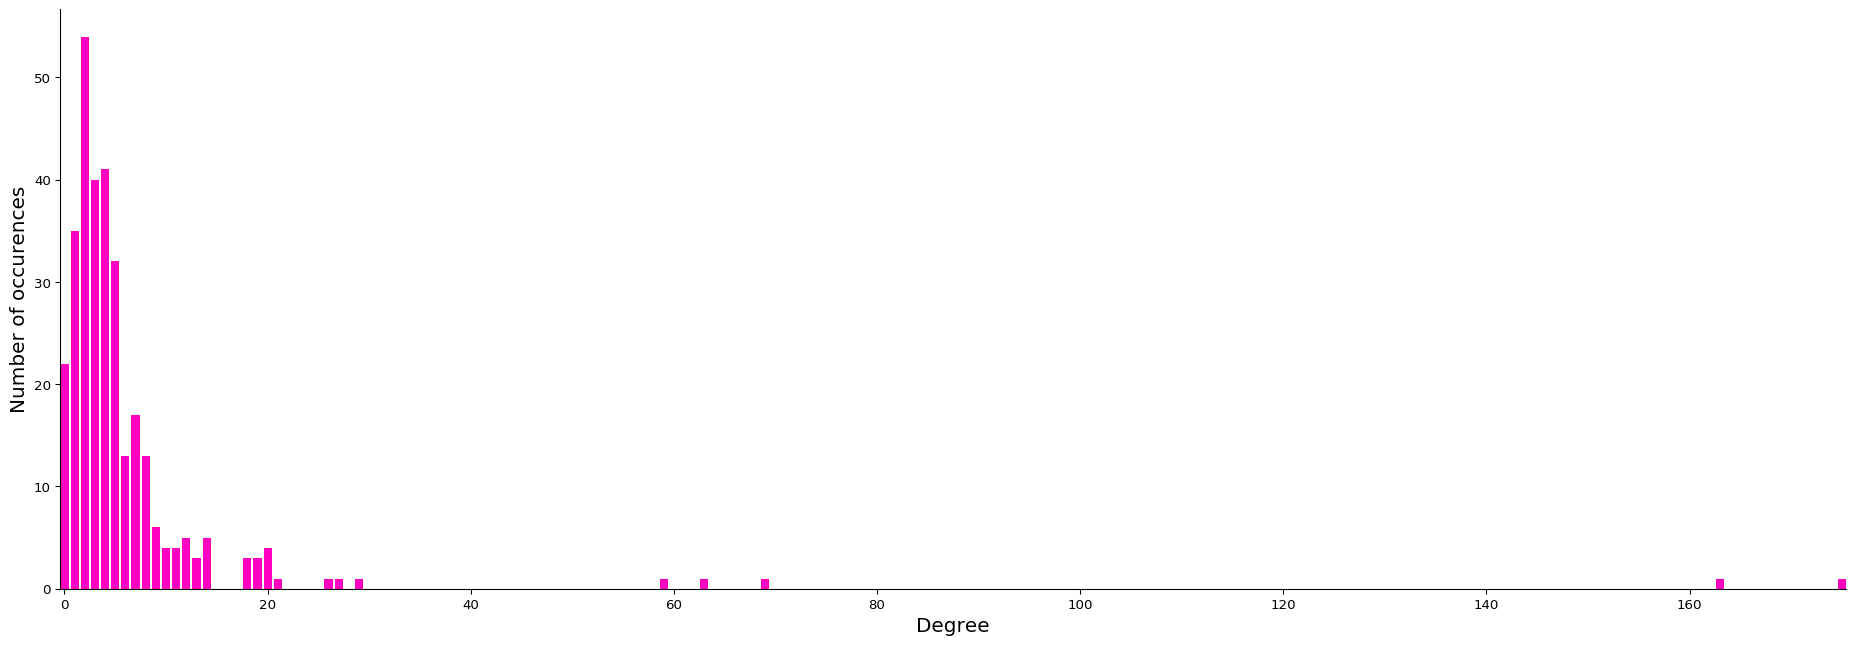

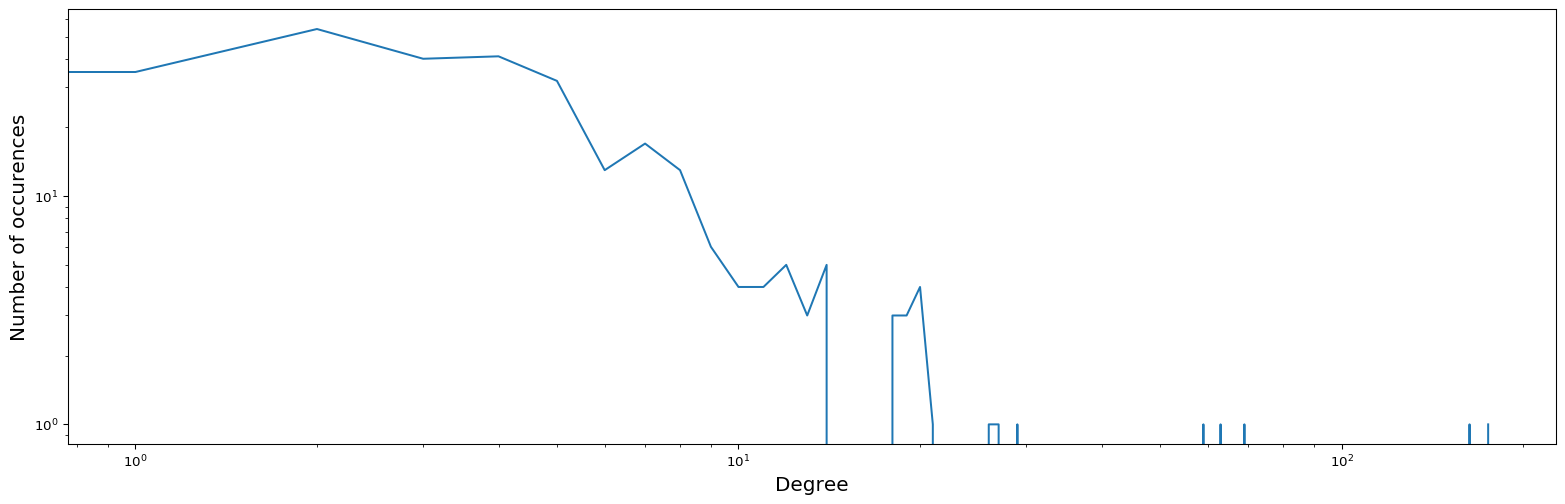

In [92]:
# degrees

# Creating plot data
max_deg = np.amax(degrees)
min_deg = np.amin(degrees)

v = range(min_deg, max_deg+2)

hist, bins = np.histogram(degrees, v)

bins = bins[:-1]

# Creating plot
plt.figure(figsize=[24,8], dpi=96)
plt.bar(bins, hist, color = color_palet['flashy pink'])
plt.margins(x=0)
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.title("Degree Distribution", fontsize=20)
plt.ylabel("Number of occurences", fontsize=15)
plt.xlabel("Degree", fontsize=15)

# for a,b in zip(bins,hist):
#  if(b != 0):
#    plt.text(a , b+1 , str(b), rotation=90)

plt.savefig(path_plots + "degree_distribution.png", format='png', transparent=True, bbox_inches='tight')
plt.show()
plt.close()

plt.figure(figsize=[20,6], dpi=96)
plt.loglog(bins, hist)

# plt.title("Degree Distribution - loglog", fontsize=20)
plt.ylabel("Number of occurences", fontsize=15)
plt.xlabel("Degree", fontsize=15)
plt.savefig(path_plots + "degree_distribution_loglog.png", format='png', transparent=True, bbox_inches='tight')
plt.show()
plt.close()

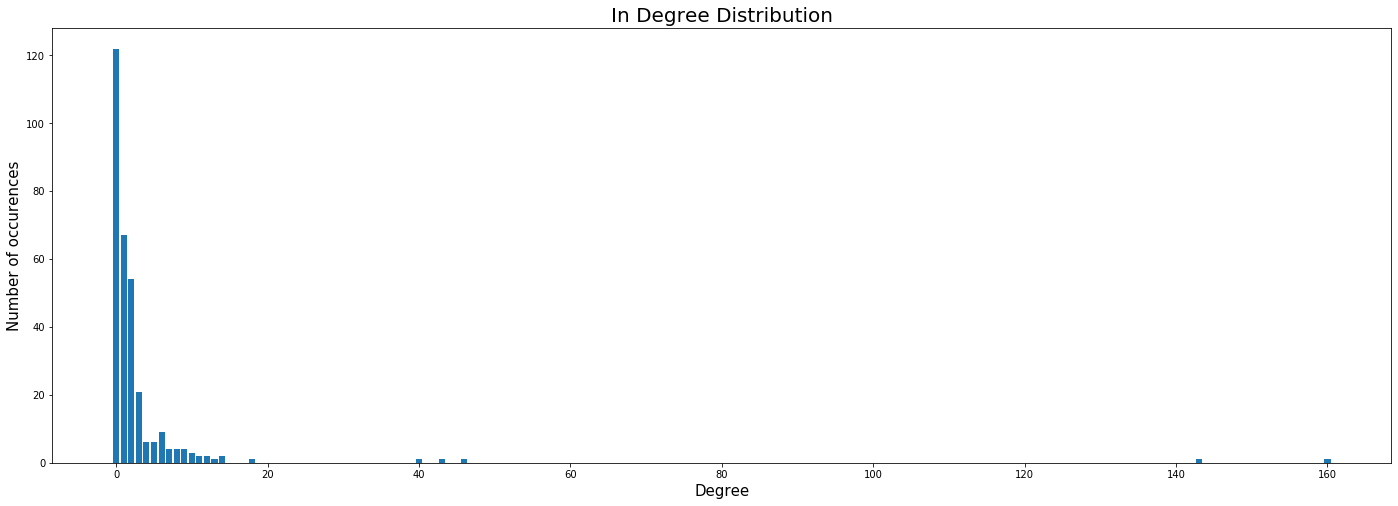

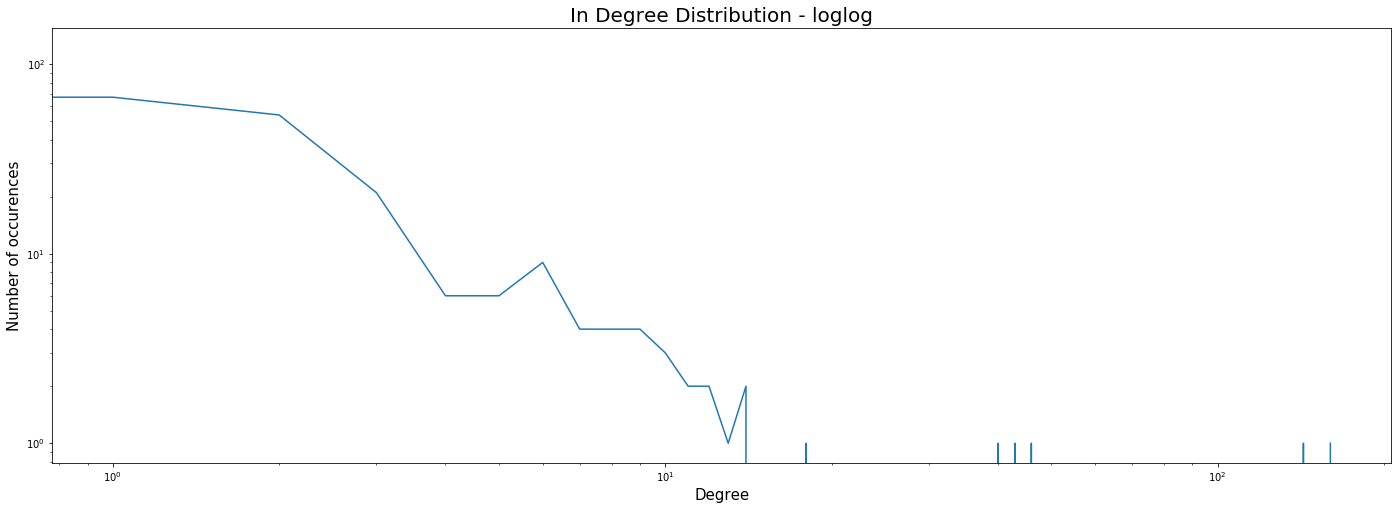

In [93]:
# in degrees
max_deg = np.amax(in_degrees)
min_deg = np.amin(in_degrees)

v = range(min_deg, max_deg+2)

hist, bins = np.histogram(in_degrees, v)

bins = bins[:-1] # Remove last bin

plt.figure(figsize=[24,8])
plt.bar(bins, hist)

plt.title("In Degree Distribution", fontsize=20)
plt.ylabel("Number of occurences", fontsize=15)
plt.xlabel("Degree", fontsize=15)
plt.savefig(path_plots + "in_degree_distribution.png", format='png', transparent=True, bbox_inches='tight')
plt.show()
plt.close()

plt.figure(figsize=[24,8])
plt.title("In Degree Distribution - loglog", fontsize=20)
plt.ylabel("Number of occurences", fontsize=15)
plt.xlabel("Degree", fontsize=15)
plt.loglog(bins, hist)
plt.savefig(path_plots + "in_degree_distribution_loglog.png", format='png', transparent=True, bbox_inches='tight')
plt.show()
plt.close()

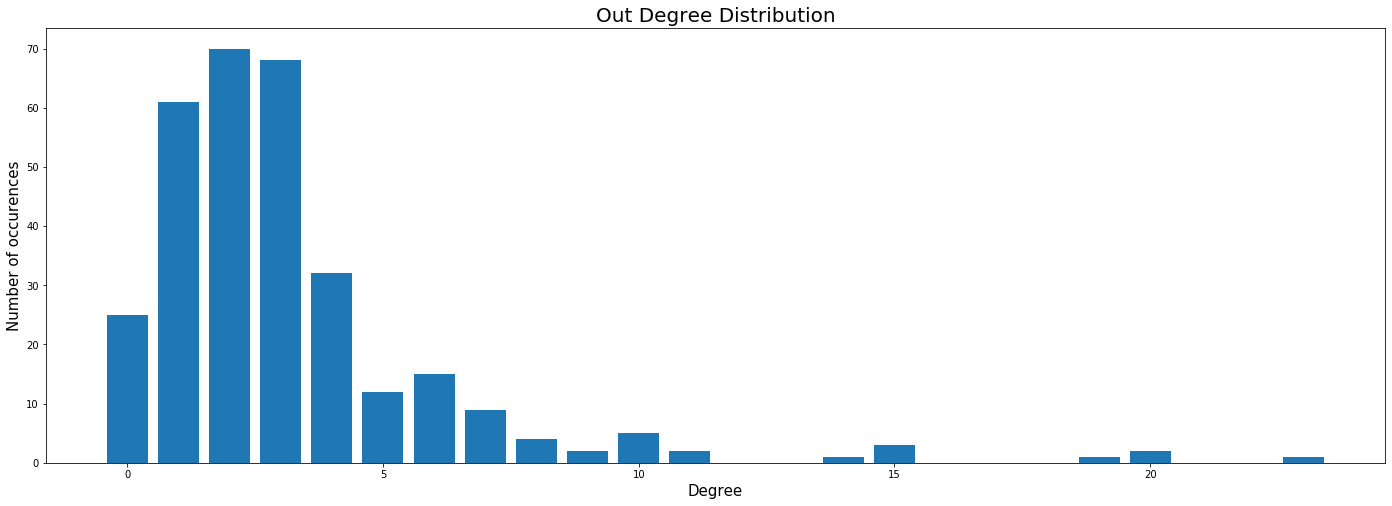

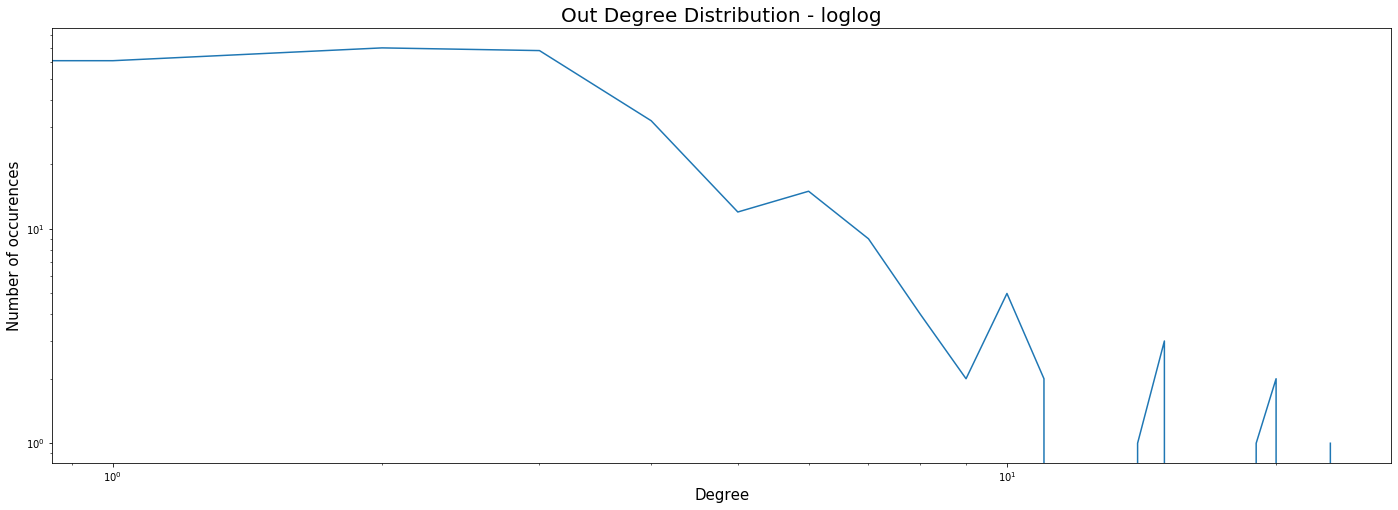

In [94]:
# out degrees
max_deg = np.amax(out_degrees)
min_deg = np.amin(out_degrees)

v = range(min_deg, max_deg+2)

hist, bins = np.histogram(out_degrees, v)

bins = bins[:-1]

plt.figure(figsize=[24,8])
plt.bar(bins, hist)

plt.title("Out Degree Distribution", fontsize=20)
plt.ylabel("Number of occurences", fontsize=15)
plt.xlabel("Degree", fontsize=15)
plt.savefig(path_plots + "out_degree_distribution.png", format='png', transparent=True, bbox_inches='tight')
plt.show()
plt.close()

plt.figure(figsize=[24,8])
plt.title("Out Degree Distribution - loglog", fontsize=20)
plt.ylabel("Number of occurences", fontsize=15)
plt.xlabel("Degree", fontsize=15)
plt.loglog(bins, hist)
plt.savefig(path_plots + "out_degree_distribution_loglog.png", format='png', transparent=True, bbox_inches='tight')
plt.show()
plt.close()

## Centralities


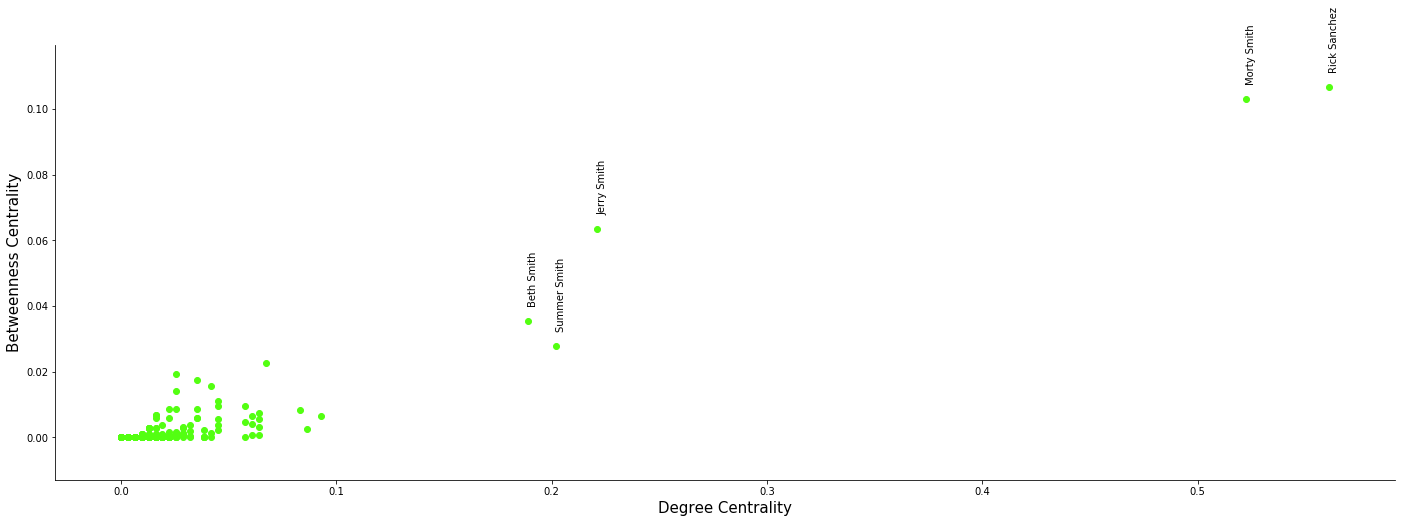

In [95]:
# Plotting Betweenness Centrality of nodes vs Degree Centrality

plt.figure(figsize=(24,8))

# removing top frames
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel("Degree Centrality", fontsize=15)
plt.ylabel("Betweenness Centrality", fontsize=15)

# Display Top 5 on graph
for a,b in zip(nx.centrality.degree_centrality(G).values(), nx.centrality.betweenness_centrality(G).values()):
  if(b >= 0.026):
    for key, value in nx.centrality.betweenness_centrality(G).items():
      if value == b:
        plt.text(a , b+0.005, key, rotation=90)

plt.scatter(nx.centrality.degree_centrality(G).values(), nx.centrality.betweenness_centrality(G).values(), color = color_palet["flashy green"])
plt.savefig(path_plots + "centrality_betweenness.png", format='png', transparent=True, bbox_inches='tight')
plt.show()
plt.close()

In [96]:
def top5_betweenness(G):
    betweenness = nx.centrality.betweenness_centrality(G)
    return sorted(betweenness, key=betweenness.get, reverse=True)[:5]
    
print('Top 5 nodes - Betweenness Centrality:')
print(top5_betweenness(G))

Top 5 nodes - Betweenness Centrality:
['Rick Sanchez', 'Morty Smith', 'Jerry Smith', 'Beth Smith', 'Summer Smith']


**Since betweenness is a measure of which node has the most shortest paths going through it, a high betweenness centrality means that this node is the character to know, to be able to get fastest from A to B in the network.
As expected, Rick and Morty are most central, followed my the remaining members of the Smith family. Jerry is probably third because he joins Rick and Morty on most adventures, compared to the other two family members.**


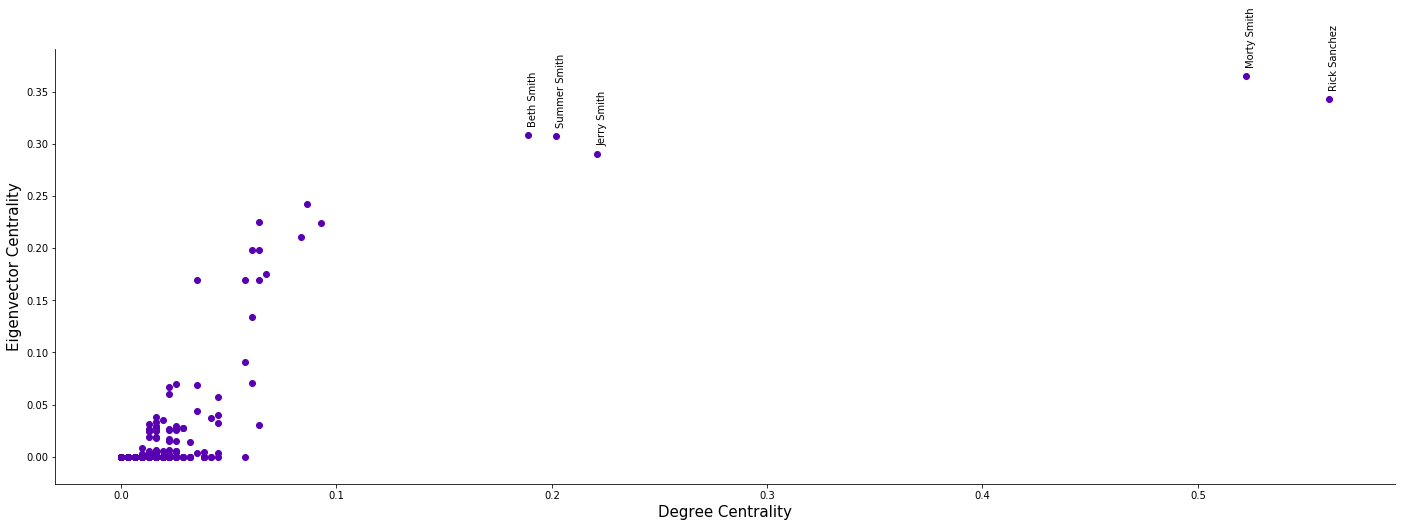

In [97]:
# Plotting Eigenvector Centrality of nodes vs Degree Centrality
plt.figure(figsize=(24,8))

# removing top frames
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# naming
plt.xlabel("Degree Centrality", fontsize=15)
plt.ylabel("Eigenvector Centrality", fontsize=15)

# plot
plt.scatter(nx.centrality.degree_centrality(G).values(), nx.centrality.eigenvector_centrality(G).values(), color = color_palet['flashy purple'])

# Display Top 5 on graph
for a,b in zip(nx.centrality.degree_centrality(G).values(), nx.centrality.eigenvector_centrality(G).values()):
  if(b >= 0.25):
    for key, value in nx.centrality.eigenvector_centrality(G).items():
      if value == b:
        plt.text(a , b+0.01, key, rotation=90)

# Saving
plt.savefig(path_plots + "centrality_eigenvector.png", format='png', transparent=True, bbox_inches='tight')
plt.show()
plt.close()

In [98]:
def top5_eigenvector(G):
    eigenvector = nx.centrality.eigenvector_centrality(G)
    return sorted(eigenvector, key=eigenvector.get, reverse=True)[:5]

print('Top 5 nodes - Eigenvector Centrality:')
print(top5_eigenvector(G))

Top 5 nodes - Eigenvector Centrality:
['Morty Smith', 'Rick Sanchez', 'Beth Smith', 'Summer Smith', 'Jerry Smith']


**The Eigenvector centrality is a measure of how nodes are connected to other nodes with high degree, and in that sense it is a kind of ranking. Characters have high eigenvector centrality probably because of popularity, i.e. they appear often with other high-degree characters.
Again, Morty and Rick appear with highest centrality, whereas Jerry is on fifth place. Perhaps, like explained above with betweenness, because he is on many adventures in different locations, where a lot of characters with low degrees appear. Simply because these characters appear in locations that make them isolated from the rest of the network.**

## Communities

**This section analyzes the communities by comparing four different algorithms for community detection. Plots are used to show the structure of communities and which of the main characters are central to a specific community. For instance if Jerry Smith is the central character in a given community nodes will be colored green to match Jerry's awesome shirt. Likewise for Rick, where nodes are colored turquoise to match his pointy hair. If Rick and Morty are both in the same community, nodes will be colored red. For each plot, node sizes are dependent on the size of the communities, such that bigger communities have bigger nodes.**

In [0]:
from networkx.algorithms import community
# identify largest connected component
Gcc = sorted(nx.connected_components(G.to_undirected()), key=len, reverse=True)
G0 = G.subgraph(Gcc[0])

In [0]:
def draw_communities(communities, name):
  print('Drawing', name, 'community. NB: Bigger communities have bigger nodes')
  node_list = dict()
  node_colors = []
  labels = []
  num_communities = len(communities)
  if name == 'louvain':
    num_communities = len(list(set(communities.values()))) - 1

  for i in range(num_communities):
    if name == 'louvain':
      this_community = [key for (key, val) in communities.items() if val == i]
    else:
      this_community = communities[i]
    
    node_list[i] = this_community
    
    if 'Rick Sanchez' in this_community and 'Morty Smith' in this_community:
      node_colors.append(color_palet['rm red'])
      labels.append('Rick and Morty')
    elif 'Rick Sanchez' in this_community and 'Morty Smith' not in this_community:
      node_colors.append(color_palet['rm brown'])
      labels.append('Rick')
    elif 'Morty Smith' in this_community and 'Rick Sanchez' not in this_community:
      node_colors.append(color_palet['rm yellow'])
      labels.append('Morty')
    elif 'Summer Smith' in this_community:
      node_colors.append(color_palet['rm pink'])
      labels.append('Summer')
    elif 'Jerry Smith' in this_community:
      node_colors.append(color_palet['rm green'])
      labels.append('Jerry')
    elif 'Beth Smith' in this_community:
      node_colors.append(color_palet['rm orange'])
      labels.append('Beth')
    else:
      node_colors.append('black')
      labels.append('Other')
  
  positions = forceatlas2.forceatlas2_networkx_layout(G0.to_undirected(), pos=None, iterations=500)
  plt.figure(figsize=(15,10), dpi=128)

  for ii in list(set(node_list)):
    nx.draw_networkx_nodes(G0.to_undirected(), 
                          positions, 
                          nodelist=node_list.get(ii), 
                          node_size=len(node_list.get(ii))*1.5, 
                          node_color=node_colors[ii], 
                          label="Community " + str(ii) + ' - ' + labels[ii])
    
      
  nx.draw_networkx_edges(G0.to_undirected(), positions, width=.5, alpha=.25)
  plt.legend()
  plt.axis('off')
  plt.savefig(path_plots + 'community_' + name + '.png', format='png', transparent=True, bbox_inches='tight')
  plt.show()
  plt.close()

91 communities in total
15 communities consisting of character names, rest are just integers
Modularity: 0.4823512200889462
Drawing greedy_modularity community. NB: Bigger communities have bigger nodes


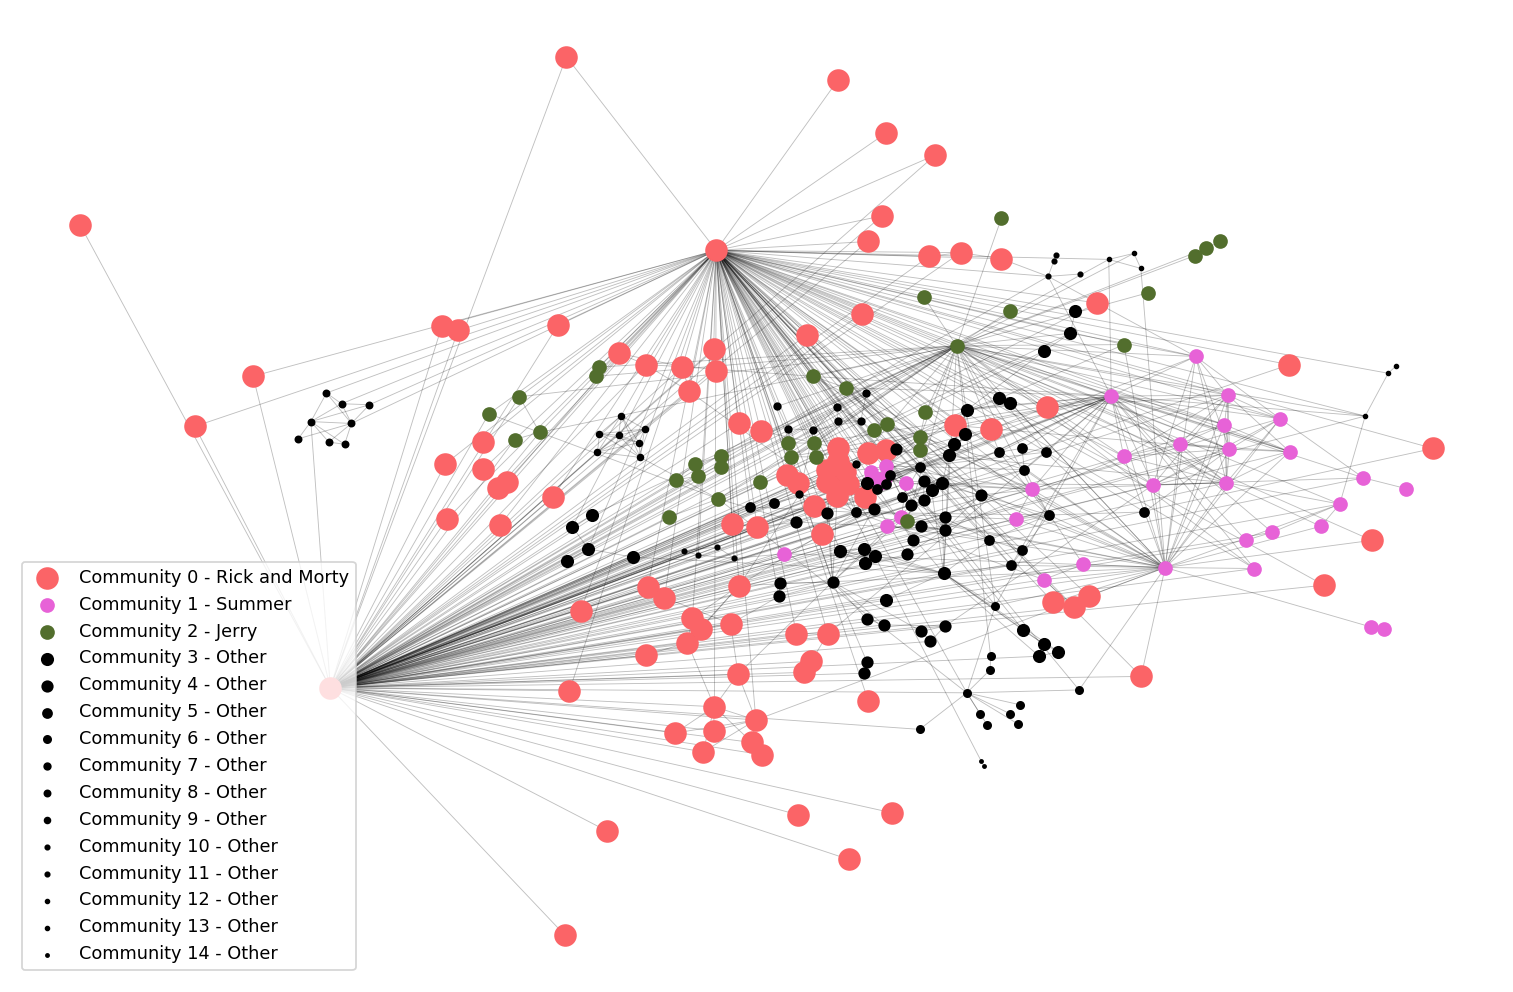

In [163]:
# Find communities with Clauset-Newman-Moore greedy modularity maximization.
# Greedy modularity maximization begins with each node in its own community 
# and joins the pair of communities that most increases modularity until no such pair exists.
c = list(community.greedy_modularity_communities(G0.to_undirected()))
communities_greedy_modularity = sorted(c[0])
print(len(communities_greedy_modularity), 'communities in total')
communities_greedy_modularity_names = [x for x in c if type(list(x)[0]) is not int]
print(len(communities_greedy_modularity_names), 'communities consisting of character names, rest are just integers')
print('Modularity:', community.modularity(G0, communities_greedy_modularity_names))
draw_communities(communities_greedy_modularity_names, 'greedy_modularity')

30 communities
Modularity: 0.4134995856717524
Drawing fluid community. NB: Bigger communities have bigger nodes


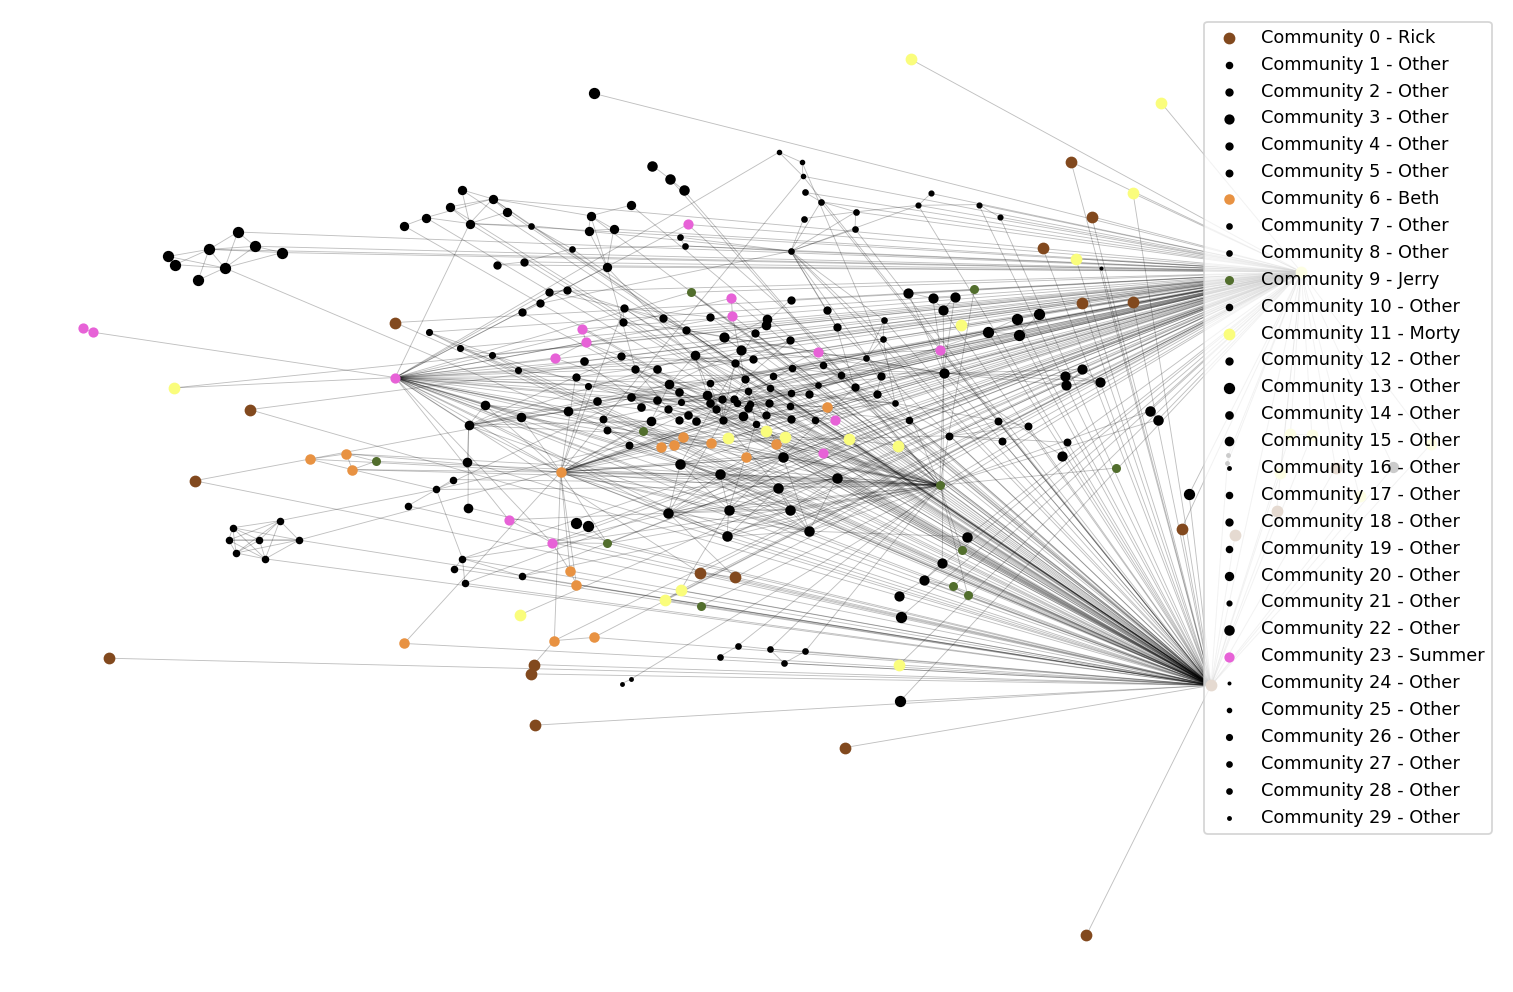

In [164]:
# Fluid Communities algorithm.
# The algorithm is based on the simple idea of fluids interacting in an environment, expanding and pushing each other.
# It’s initialization is random, so found communities may vary on different executions.
num_communities = 30
communities_fluid = sorted(map(sorted, community.asyn_fluidc(G0.to_undirected(), num_communities)))
print(len(communities_fluid), 'communities')
print('Modularity:', community.modularity(G0, communities_fluid))
draw_communities(communities_fluid, 'fluid')

16 communities
Modularity: 0.2756390023657373
Drawing label_propagation community. NB: Bigger communities have bigger nodes


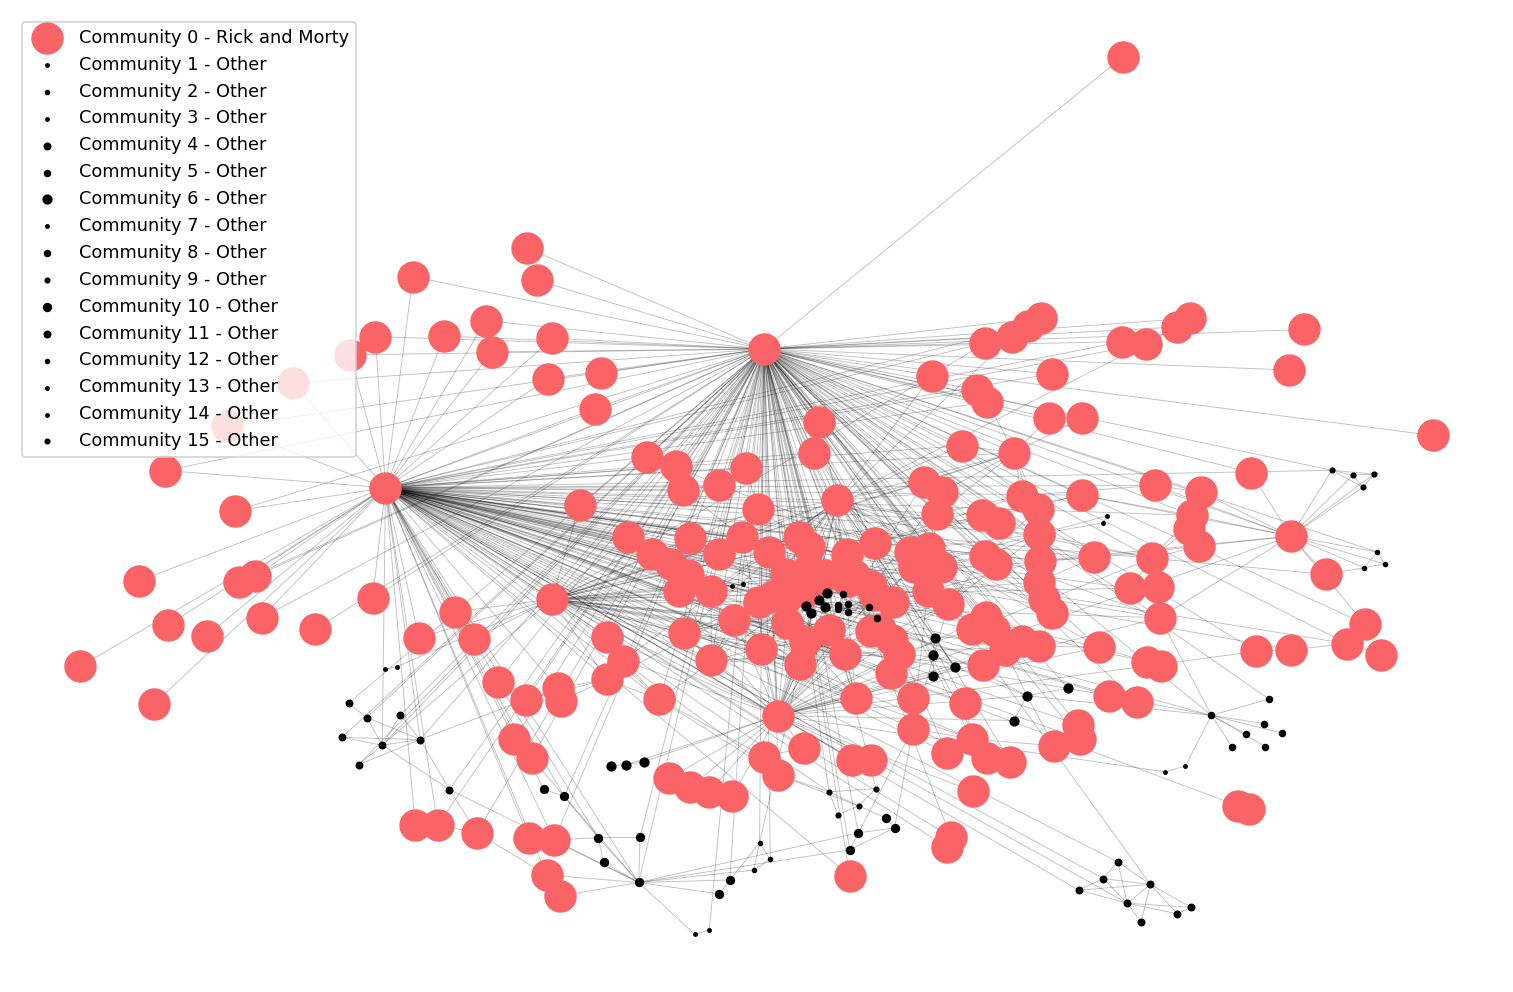

In [165]:
# Asynchronous label propagation
# The algorithm is probabilistic and the found communities may vary on different executions.
# After initializing each node with a unique label, the algorithm repeatedly sets the label of a node 
# to be the label that appears most frequently among that nodes neighbors. 
# The algorithm halts when each node has the label that appears most frequently among its neighbors. 
communities_label_propagation = sorted(map(sorted, community.asyn_lpa_communities(G0.to_undirected())))
print(len(communities_label_propagation), 'communities')
print('Modularity:', community.modularity(G0, communities_label_propagation))
draw_communities(communities_label_propagation, 'label_propagation')

9 communities
Modularity: 0.45343793402708404
Drawing louvain community. NB: Bigger communities have bigger nodes


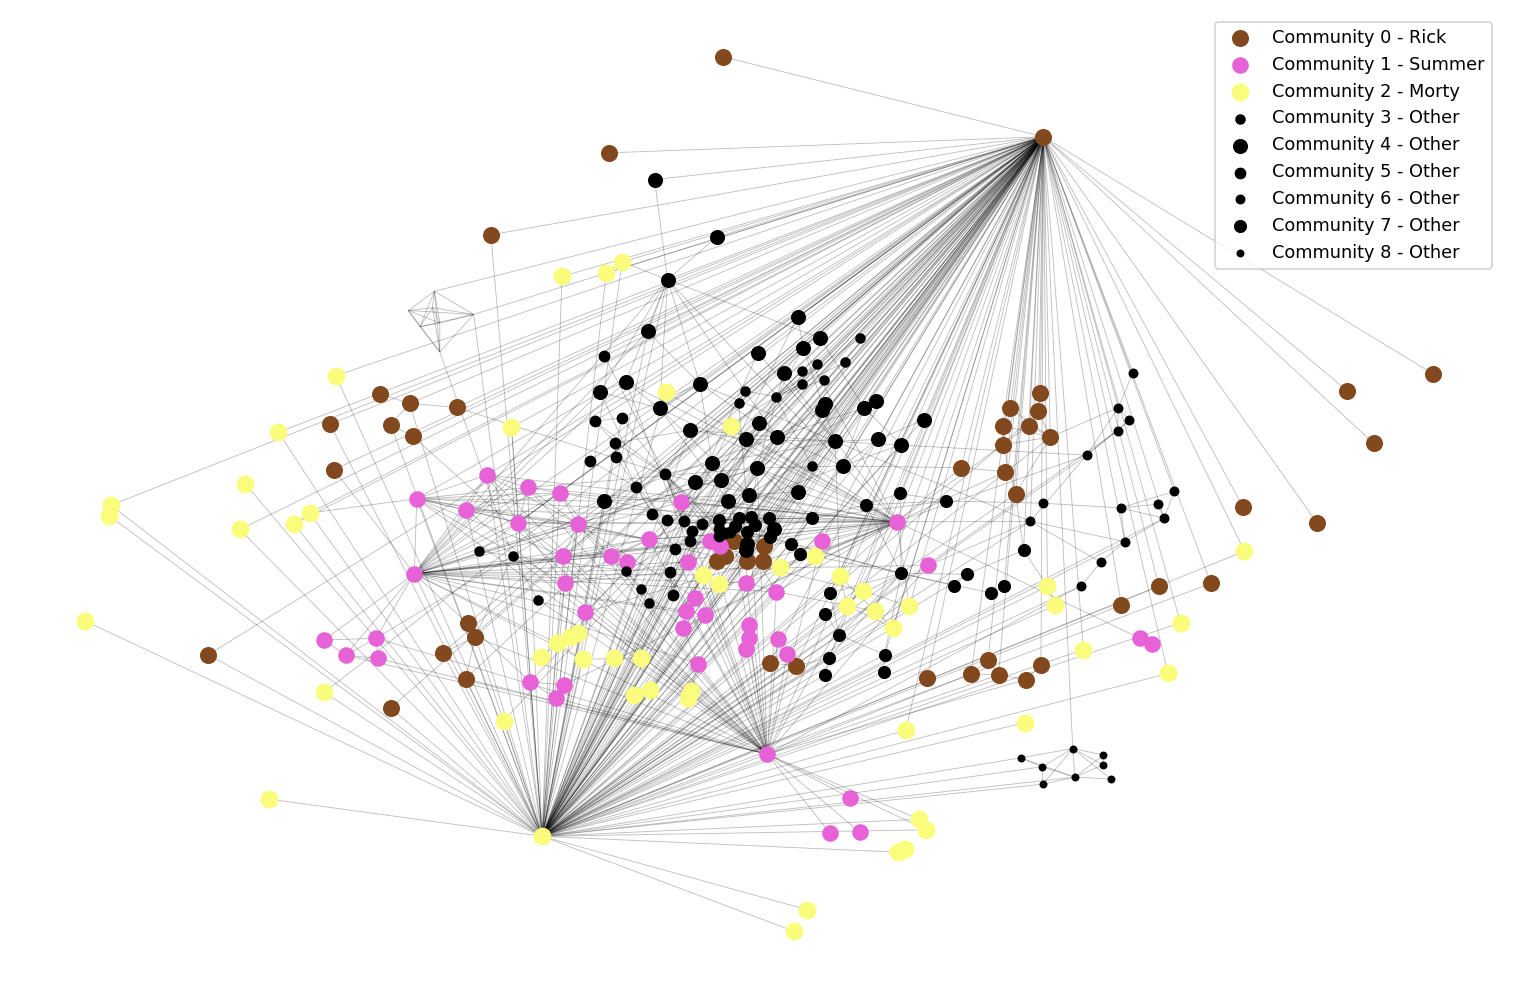

In [166]:
# Louvain algorithm
# Community is based on optimization of modularity, by intially grouping nodes locally
# The approach is similar to that of Clauset, Newman and Moore
from community import community_louvain
communities_louvain = community_louvain.best_partition(G0.to_undirected())
print(np.max(list(communities_louvain.values())), 'communities')

modularity = community_louvain.modularity(communities_louvain, G0.to_undirected())
print("Modularity:", modularity)
draw_communities(communities_louvain, 'louvain') 

## The most dangerous characters

In [0]:
dead_neighbors = dict();
for c in G.to_undirected():
    neighbors = nx.neighbors(G.to_undirected(), c);
    dead_neighbors[c] = 0;
    for n in neighbors:
      neighbor_status = nx.get_node_attributes(G.to_undirected(), 'Status').get(n);      
      if neighbor_status == "Dead":
        dead_neighbors[c] = dead_neighbors[c] + 1;

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


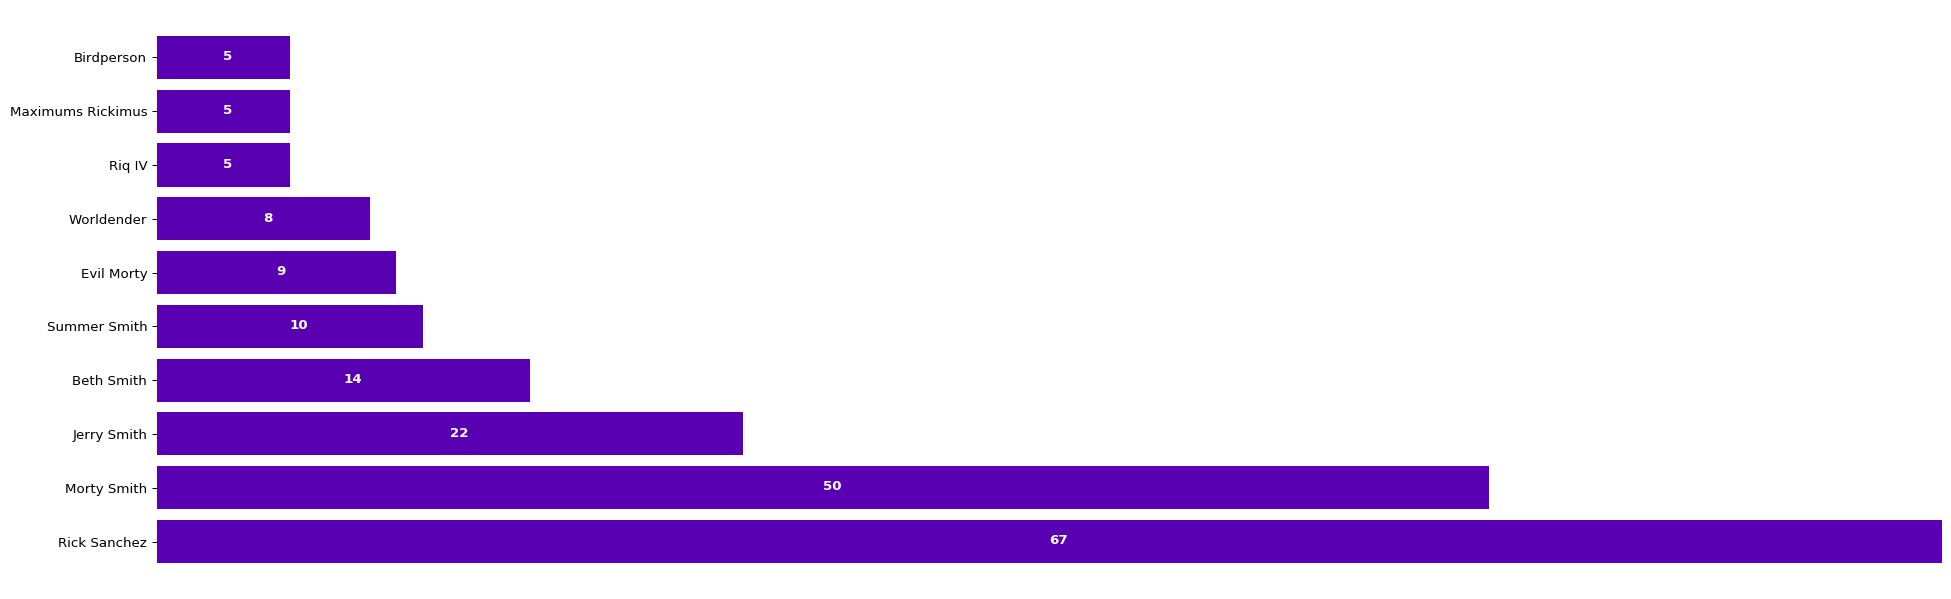

In [148]:
def top10_dead_neighbors():
    return sorted([(key, val) for (val, key) in dead_neighbors.items()], reverse=True)[:10]

names = []
death = []

for i in range(0,len(top10_dead_neighbors())):
  names.append(top10_dead_neighbors()[i][1])
  death.append(top10_dead_neighbors()[i][0])


# Creating plot
plt.figure(figsize=[24,8], dpi=96)
plt.barh(names, death, color = color_palet["flashy purple"])
plt.margins(x=0)
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.get_xaxis().set_visible(False)
ax.spines['left'].set_visible(False)

i = -0.05;

for a,b in zip(names,death):
    plt.text(b - b/2 , i , str(b), weight='bold', color="white")
    i += 1

plt.savefig(path_plots + "most_dangerous.png", format='png', transparent=True, bbox_inches='tight')
plt.show()
plt.close()

**It's without any surprise that Rick & Morty are the most dangerous characters but the, apparently, otherwise innocent father, Jerry Smith, gets the third place in our rankings of most dangerous character in the whole series, beating his own wife & daughter. Even though those characters also have a lot of nodes and appears often so their chance of being next to dead characters also increase. But when we forget about the Smith family we also stumble on the infamous Evil Morty, & Worldender. Not surprising again but Beth & Summer better work on their danger game during season 4 otherwise Evil Morty might pass them !**

## Plotting Networks

### Character Network (Ricks & Mortys)

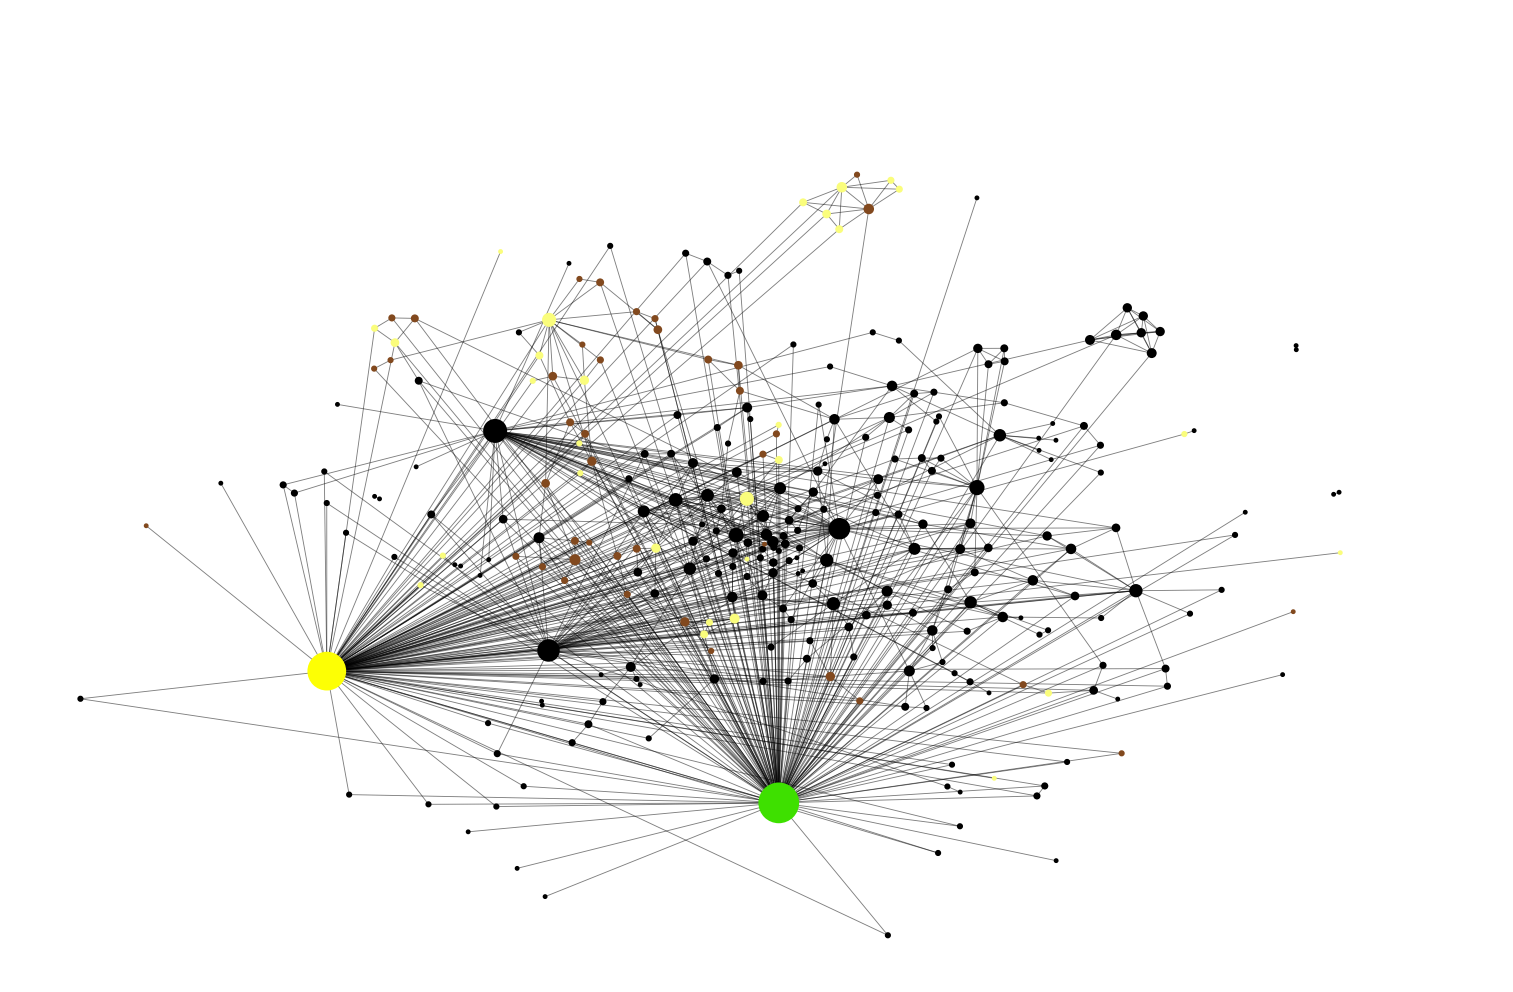

In [108]:
node_colors = []

# Color nodes based on party
for c in G.to_undirected():
    # specie = nx.get_node_attributes(G.to_undirected(), 'Specie').get(c)
    if "Rick" in c:
      color = color_palet["rm brown"]
    elif "Morty" in c:
      color = color_palet["rm yellow"]
    else:
      color = color_palet["black"]

    if c == 'Rick Sanchez':
        color = '#3ee000'
    elif c == 'Morty Smith':
        color = '#fdff04'
    
    node_colors.append(color)

# Assign node sizes based on degree
node_sizes = [degree * 3 for (n, degree) in nx.degree(G.to_undirected())]

positions_undirected = forceatlas2.forceatlas2_networkx_layout(G.to_undirected(), pos=None, iterations=500)

plt.figure(figsize=(15,10),dpi=128)
# plt.title('Characters network', fontsize = 20)
nx.draw_networkx_nodes(G.to_undirected(), positions_undirected, node_size=node_sizes, with_labels=False, node_color=node_colors)
nx.draw_networkx_edges(G.to_undirected(), positions_undirected, width=.5, alpha=.5)
plt.axis('off')
plt.savefig(path_plots + "characters_network.png", format='png', transparent=True, bbox_inches='tight')
plt.show()

### Character Network (Ricks & Mortys w/ Images)

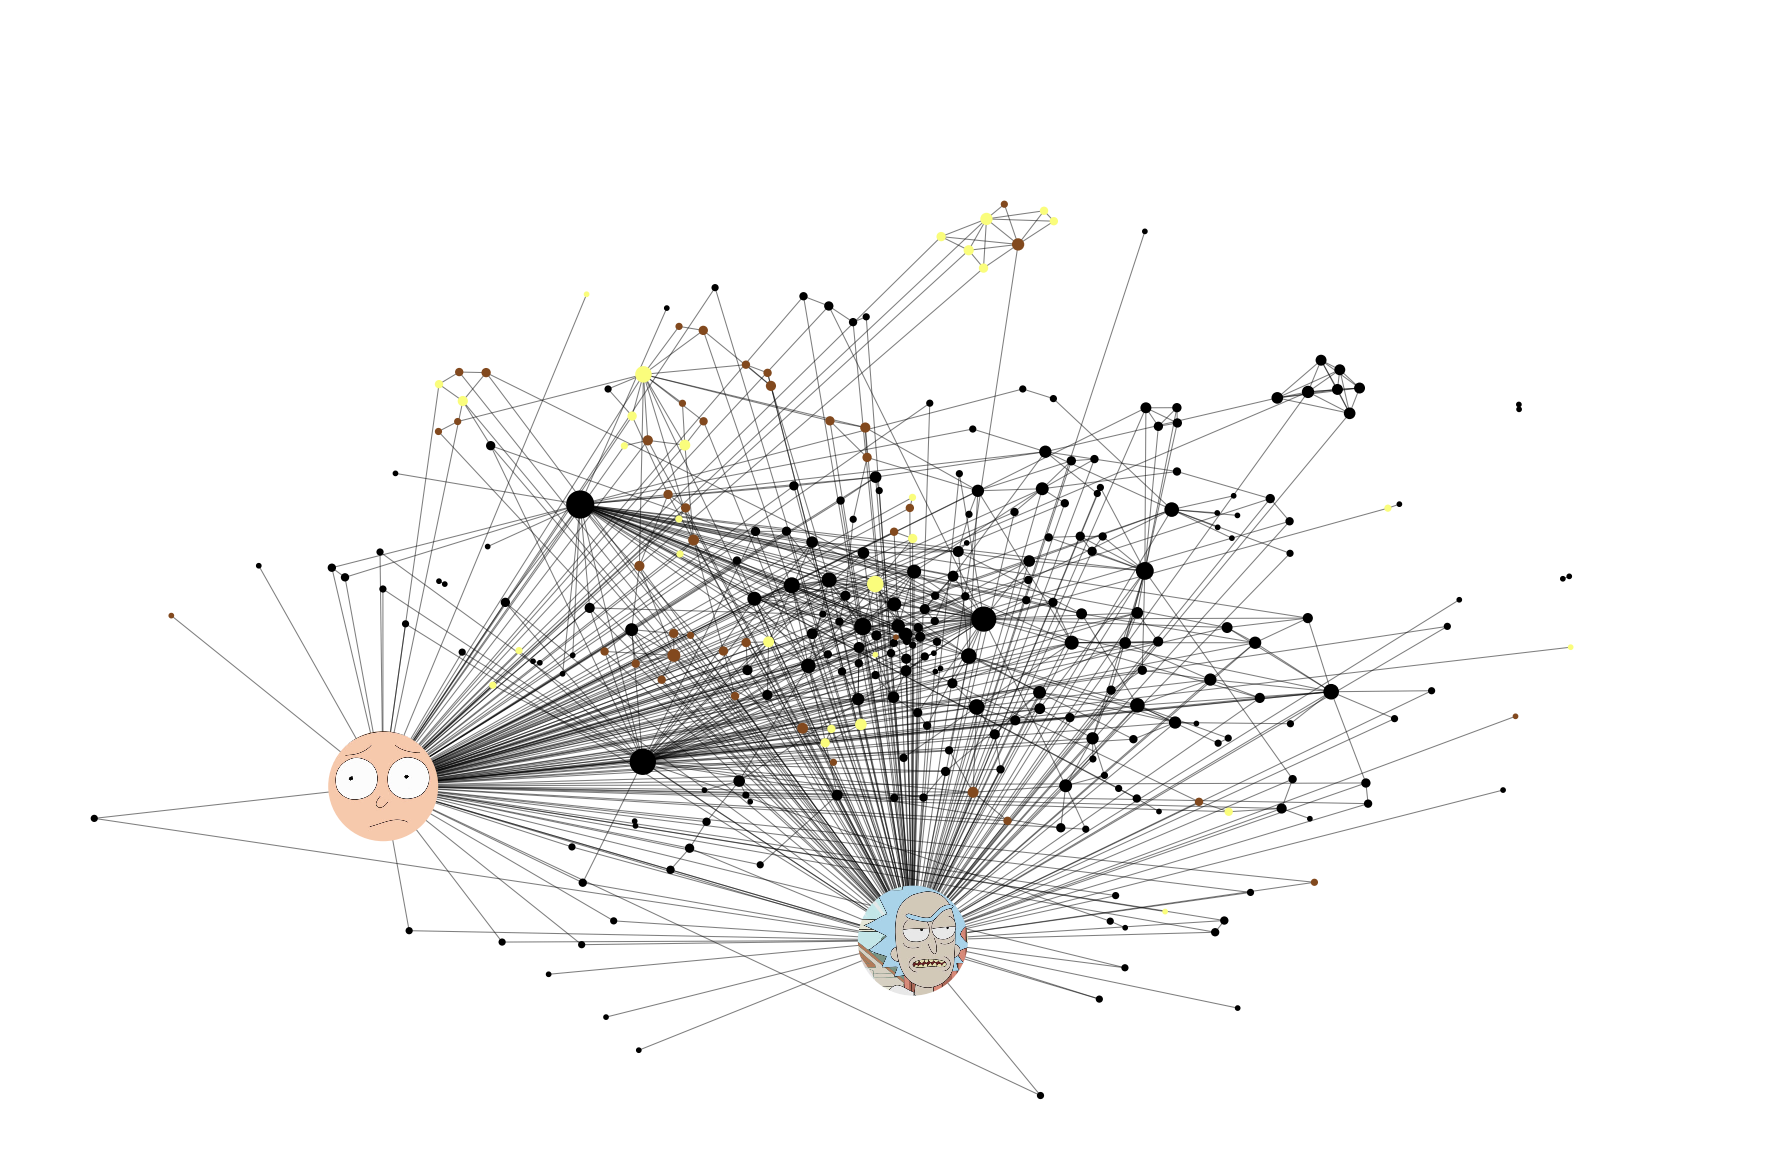

In [109]:
import matplotlib.patches as patches

plt.figure(figsize=(15,10),dpi=150)
# plt.title('Characters network with images', fontsize = 20)
nx.draw_networkx_nodes(G.to_undirected(), positions_undirected, node_size=node_sizes, with_labels=False, node_color=node_colors)
nx.draw_networkx_edges(G.to_undirected(), positions_undirected, width=.5, alpha=.5)
plt.axis('off')

ax=plt.gca()
fig=plt.gcf()
trans = ax.transData.transform
trans2 = fig.transFigure.inverted().transform
imsize = 0.1 # this is the image size
for n in G.nodes():
  if n == 'Rick Sanchez' or n == 'Morty Smith':
    (x,y) = positions_undirected[n]
    xx,yy = trans((x,y)) # figure coordinates
    xa,ya = trans2((xx,yy)) # axes coordinates
    a = plt.axes([xa-imsize/2.0,ya-imsize/2.0, imsize, imsize ])
    im = a.imshow(nx.get_node_attributes(G, 'Image')[n], aspect='equal')
    # Round images
    patch = patches.Circle((150,150), 110, facecolor='none')
    a.add_patch(patch)
    im.set_clip_path(patch)
    a.axis('off')
plt.savefig(path_plots + "characters_network_img.png", format='png', transparent=True, bbox_inches='tight')
plt.show()

### Character Network (Status)

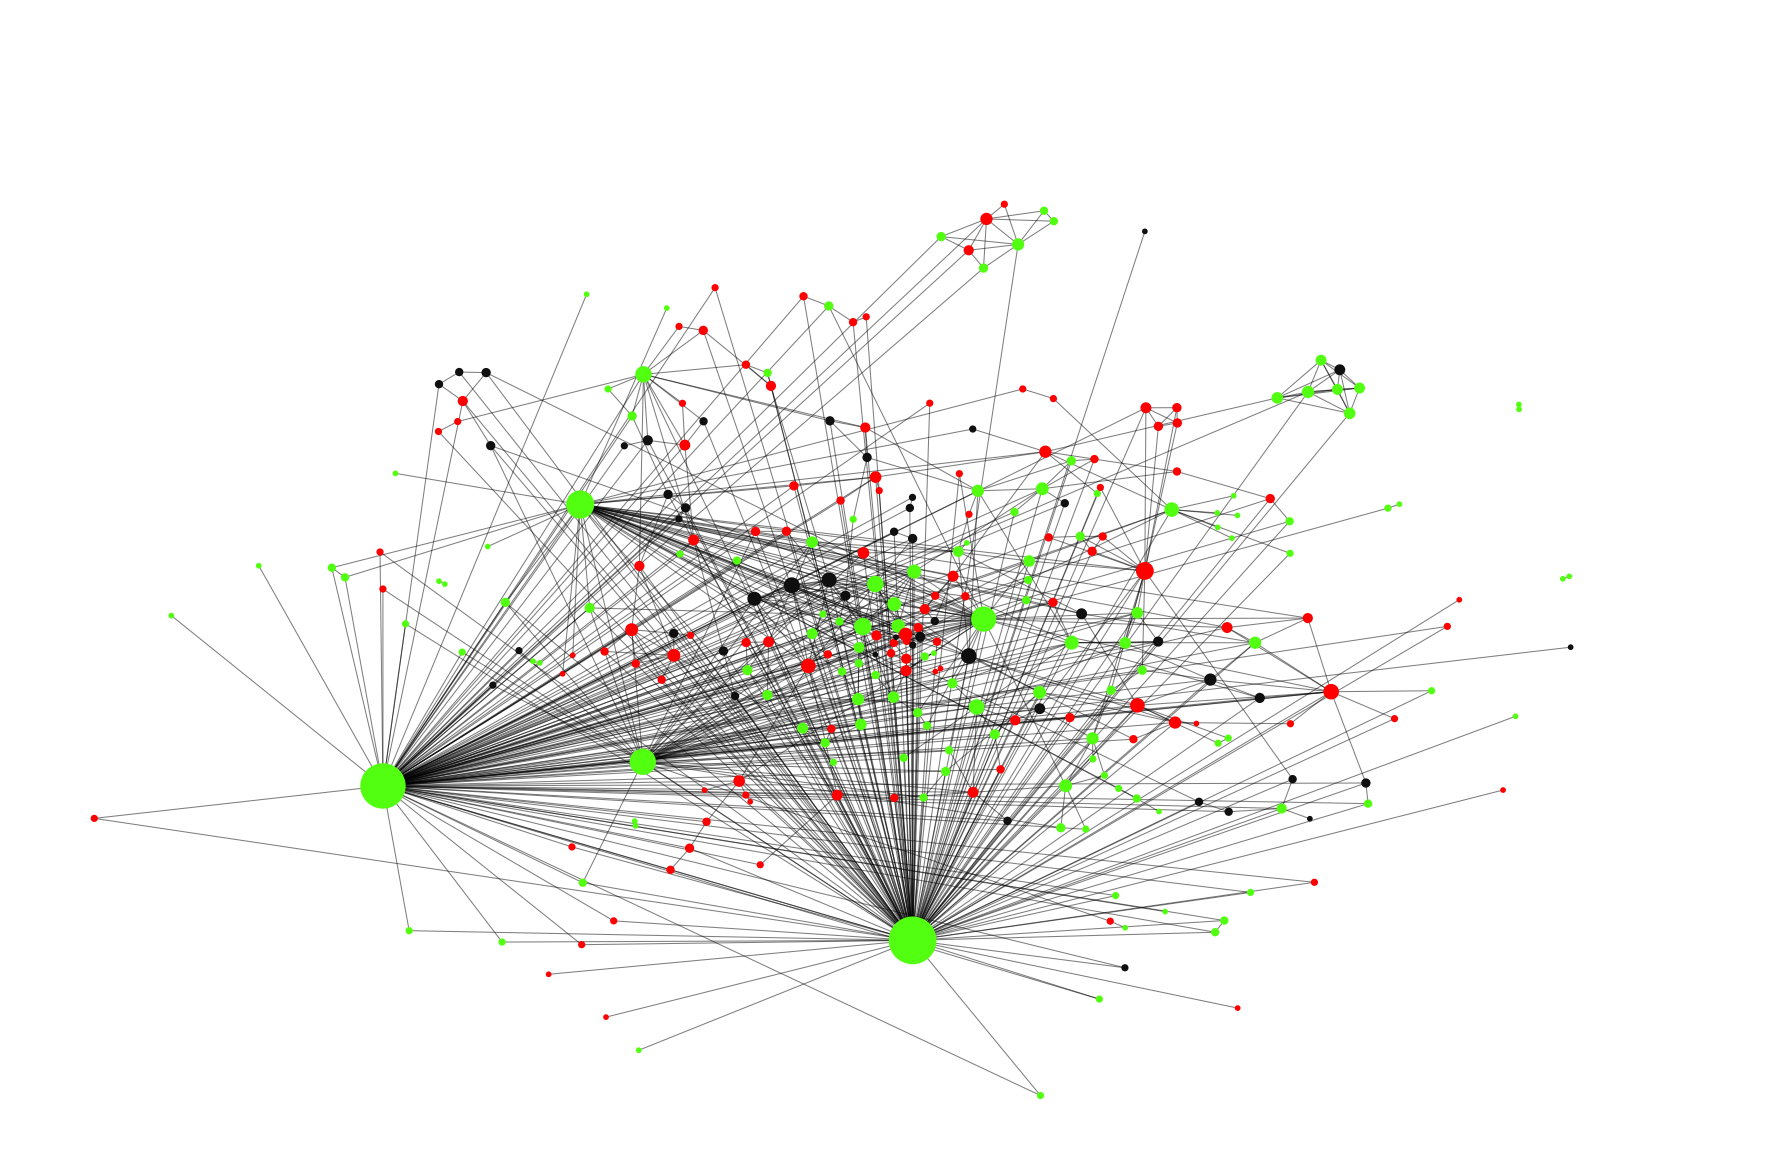

In [111]:
node_colors = []

# Color nodes based on status
for c in G.to_undirected():
    status = nx.get_node_attributes(G.to_undirected(), 'Status').get(c)
    if status == "Dead":
      color = 'red';
    elif status == "Alive":
      color = color_palet["flashy green"]
    elif status == "unknown":
      color = "#0f0f0f"
    
    node_colors.append(color)

plt.figure(figsize=(15,10),dpi=150)
# plt.title('Characters Status', fontsize = 20)
nx.draw_networkx_nodes(G.to_undirected(), positions_undirected, node_size=node_sizes, with_labels=False, node_color=node_colors)
nx.draw_networkx_edges(G.to_undirected(), positions_undirected, width=.5, alpha=.5)
plt.axis('off')
plt.savefig(path_plots + "characters_network_status.png", format='png', transparent=True, bbox_inches='tight')
plt.show()

### Character Network (Specie)

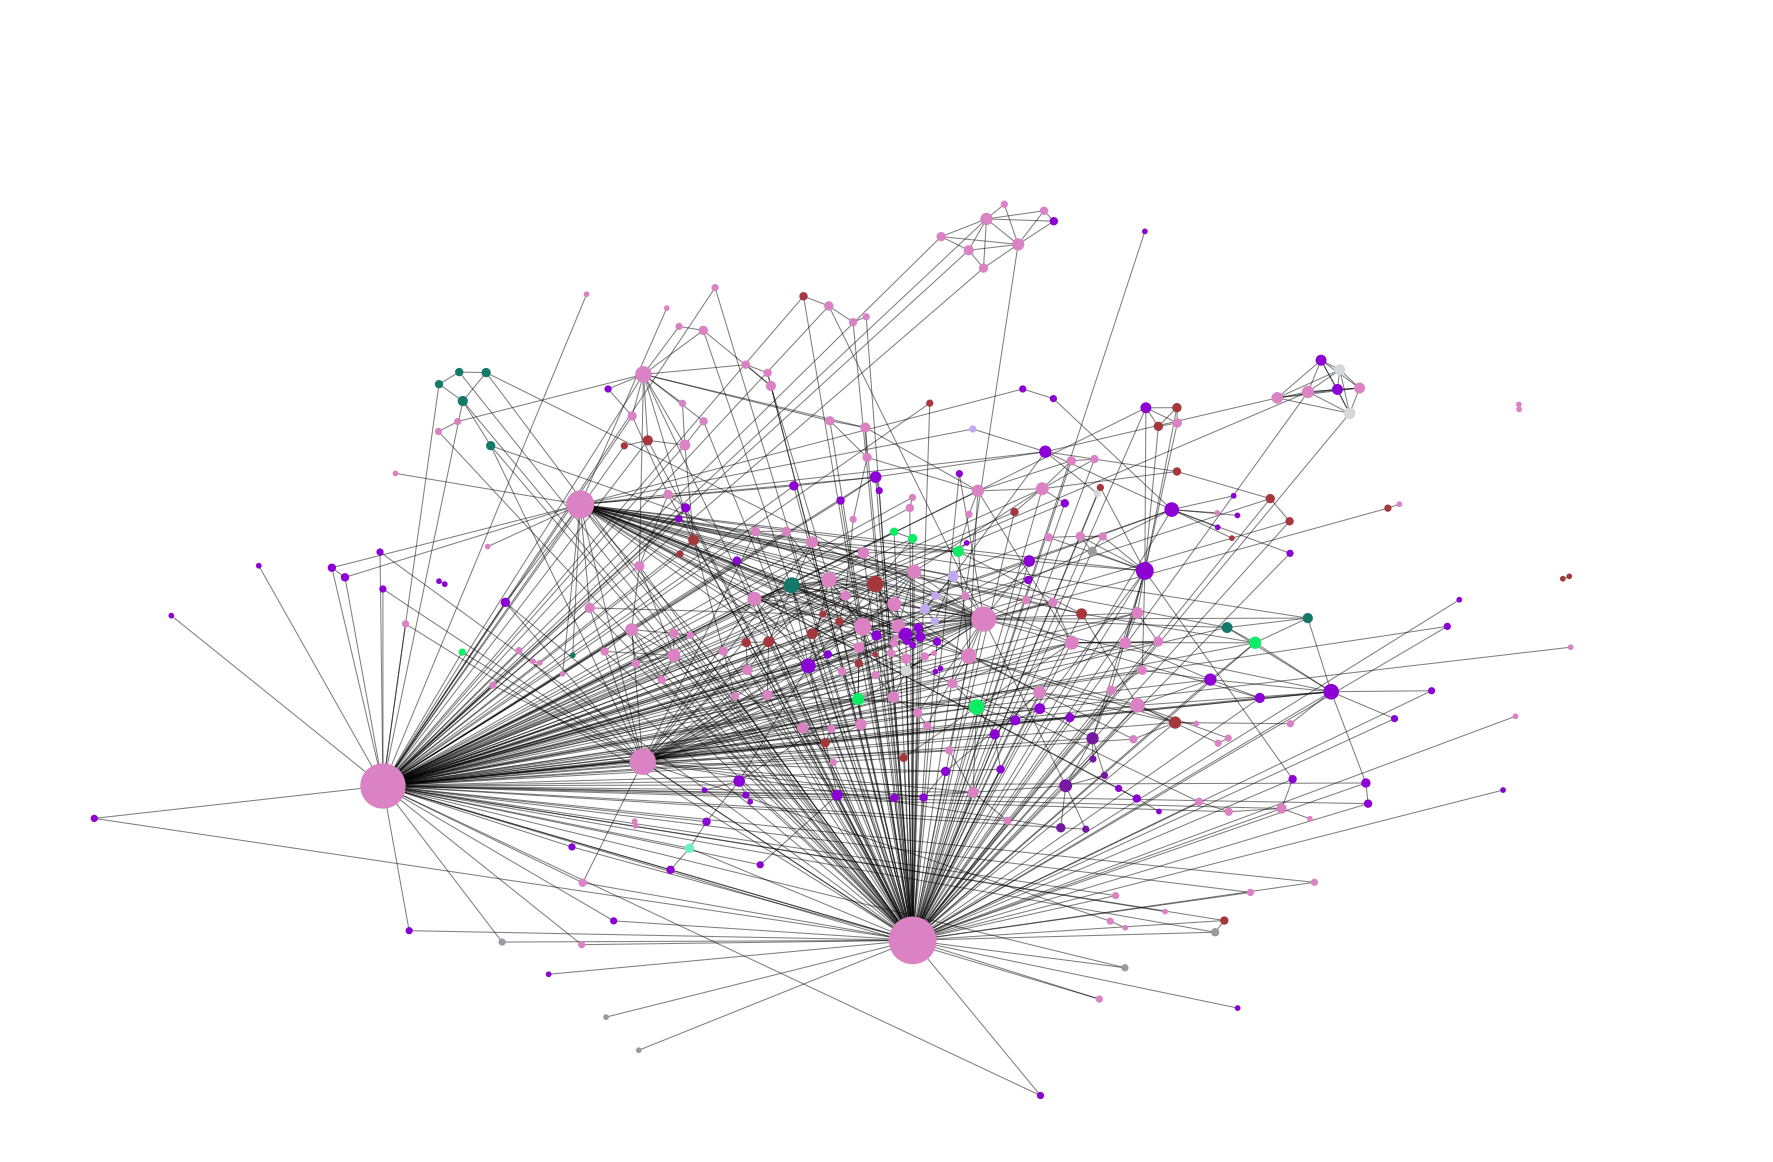

In [167]:
node_colors = []
species_colors = {}
# Color nodes based on specie
for c in G.to_undirected():
    specie = nx.get_node_attributes(G.to_undirected(), 'Specie').get(c)
    if specie in species_colors.keys():
      color = species_colors[specie]
    else:
      color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
      species_colors[specie] = color

    node_colors.append(color)

plt.figure(figsize=(15,10),dpi=150)
# plt.title('Characters Species', fontsize = 20)
nx.draw_networkx_nodes(G.to_undirected(), positions_undirected, node_size=node_sizes, with_labels=False, node_color=node_colors)
nx.draw_networkx_edges(G.to_undirected(), positions_undirected, width=.5, alpha=.5)
plt.axis('off')
plt.savefig(path_plots + "characters_network_species.png", format='png', transparent=True, bbox_inches='tight')
plt.show()

# Rick and Morty Analysis

## Sentiment function

In [0]:
url = "https://ndownloader.figshare.com/files/360592"
s = requests.get(url).content
st = s.decode('utf-8')
# Cutting first two lines
sentiments = st.split("\n",2)[2];

df_sent = pd.read_csv(io.StringIO(sentiments), sep="\t",encoding = 'utf-8')
key_words = df_sent['word'].tolist()

In [0]:
def sentiment(tokens):
    # Adding happiness of every word
    sum = 0
    for token in tokens:
      # Checking if we can evaluate the sentiment of the word
        if(token in key_words):
            sum += df_sent.loc[df_sent['word'] == token].iloc[0].happiness_average
    # Returning the average
    return sum/len(tokens)

##Extracting transcripts from files

In [69]:
for i in range(0,len(df_ep)):
  name = df_ep.iloc[i]['Name']
  code = df_ep.iloc[i]['Code']

  if("S01" in code):
    if("9" in name):
      name = name.replace("#9","9")
    if(":" in name):
      name = name.replace(":","-")

    path = "./transcripts/Season 1/" +  name + ".json"
  elif ("S02" in code):
    if(":" in name):
      name = name.replace(":","-")
    path = "./transcripts/Season 2/" + name + ".json"
  elif ("S03" in code):
    if(":" in name):
      name = name.replace(":","-")
    if ("The Ricklantis Mixup" in name):
      name = "Tales From the Citadel"
    path = "./transcripts/Season 3/" + name + ".json"

  if os.path.isfile(path):
    # Get the text
    content = io.open(path, encoding='utf-8').read()
    df_ep.set_value(i,'Transcript', content)
  
banned_words = set(stopwords.words('english'))
banned_words.add('br')
banned_words.add('p')
banned_words.add('mr')
banned_words.add('span')
banned_words.add('arial')
banned_words.add('baseline')
banned_words.add('italic')

characters_names = list(df['Name'])
characters_names = [x.lower() for x in characters_names]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


## Preparation of lists of tokens for Rick and Morty

In [0]:
#function returing the list of tokens for the season, half of season, and character given
#for now it catches only '''Morty:''' text ''' formatting and '''Morty'''

#ex season='01', char='Morty' half=1
def getwords(season,char,half):
  words=[]

  sw=set(stopwords.words('english'))
  tokens=[]
  for row in df_ep.iterrows():
    if str(row[1][1])[:3]=='S'+season:
      if (int(str(row[1][1])[5:6])<6 and half==1) or (int(str(row[1][1])[5:6])>=6 and half==2):
        verse=row[1][4]

        phrase="'''"+char+":'''.+?(?=''')"
        found1 = re.findall(phrase, verse, re.S)

        phrase="'''"+char+"'''.+?(?=\n''')"
        found2 = re.findall(phrase, verse, re.S)

        #phrase="("+char+":).+?(?=\w+:)"
        #found3 = re.findall(phrase, verse, re.S)
        
        for ii in range(0,len(found1)):
          found1[ii]=found1[ii][(7+len(char)):]

        for ii in range(0,len(found2)):
          found2[ii]=found2[ii][(6+len(char)):]

        #for ii in range(0,len(found3)):
        #  found3[ii]=found3[ii][(1+len(char)):]


        found=found1+found2#+found3
        
        
        
        #tokenize
        for ff in found:
          tokens+=word_tokenize(ff)

        #to lower
        tokens=[tt.lower() for tt in tokens]

        #excluding stopwords
        tokens = [t for t in tokens if not t in sw]

        #excluding punctuation and numbers
        for ii in range(0,len(tokens)):
          tokens[ii]=''.join(e for e in tokens[ii] if e.isalpha())
        tokens = [t for t in tokens if t!='']

        #append
        words+=tokens
    

  return words



In [0]:
M1a=getwords('01', 'Morty',1)
M1b=getwords('01', 'Morty',2)
M2a=getwords('02', 'Morty',1)
M2b=getwords('02', 'Morty',2)
M3a=getwords('03', 'Morty',1)
M3b=getwords('03', 'Morty',2)
R1a=getwords('01', 'Rick',1)
R1b=getwords('01', 'Rick',2)
R2a=getwords('02', 'Rick',1)
R2b=getwords('02', 'Rick',2)
R3a=getwords('03', 'Rick',1)
R3b=getwords('03', 'Rick',2)


## Swearing analysis

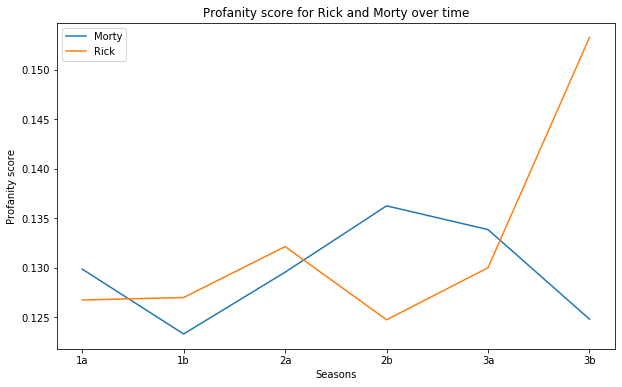

In [72]:
a=[M1a,M1b,M2a,M2b,M3a,M3b]
b=[R1a,R1b,R2a,R2b,R3a,R3b]

a1=[M1a+M1b,M2a+M2b,M3a+M3b]
b1=[R1a+R1b,R2a+R2b,R3a+R3b]

x=['1a','1b', '2a', '2b', '3a', '3b']
x1=['1','2','3']

yM=[predict_prob(ii).mean() for ii in a]
yR=[predict_prob(ii).mean() for ii in b]

yM1=[predict_prob(ii).mean() for ii in a1]
yR1=[predict_prob(ii).mean() for ii in b1]

plt.figure(figsize=(10,6))
plt.plot(x, yM, yR)
plt.title("Profanity score for Rick and Morty over time")
plt.ylabel("Profanity score")
plt.xlabel("Seasons")
plt.legend(["Morty", "Rick"])
plt.show()



## Sentiment analysis

In [0]:
sM1a = sentiment(M1a)
sM1b = sentiment(M1b)
sM2a = sentiment(M2a)
sM2b = sentiment(M2b)
sM3a = sentiment(M3a)
sM3b = sentiment(M3b)
sR1a = sentiment(R1a)
sR1b = sentiment(R1b)
sR2a = sentiment(R2a)
sR2b = sentiment(R2b)
sR3a = sentiment(R3a)
sR3b = sentiment(R3b)


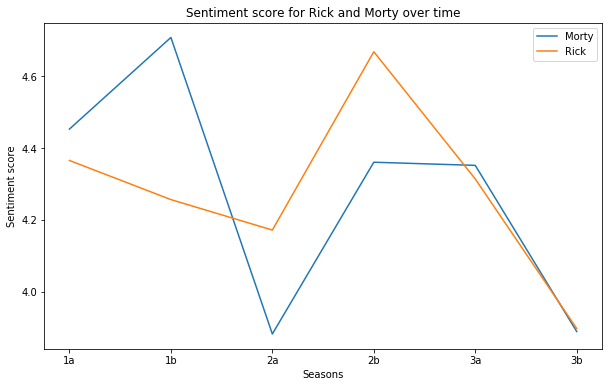

In [74]:
x=['1a','1b', '2a', '2b', '3a', '3b']
a=[sM1a,sM1b,sM2a,sM2b,sM3a,sM3b]
b=[sR1a,sR1b,sR2a,sR2b,sR3a,sR3b]

plt.figure(figsize=(10,6))
plt.plot(x, a, b)
plt.title("Sentiment score for Rick and Morty over time")
plt.ylabel("Sentiment score")
plt.xlabel("Seasons")
plt.legend(["Morty", "Rick"])
plt.show()

## TF-IDF

##

In [0]:
def tf_idf(tokens1, tokens2):
  # TF Term Frequency 
  count = {}
  for ii in tokens1:
      if ii in count:
          count[ii] += 1
      else:
          count[ii] = 1
    
  # IDF Inverse Data Frequency
  idf = {}
  for ii in count:
      if ii in tokens2:
        n = 2
      else:
        n = 1
      idf[ii]=math.log(2/n)

  # TF-IDFtfidf = {}
  for ii in s1_count:
      tfidf[ii] = count[ii] * idf[ii]

  return tfidf

# Sentiment Analysis

## Tokenizing & Sentiment Calculation

In [76]:
# Adding Column to df
df_ep['Sentiment Score'] = 0.00

# Seasons tokens
s1_tk = []
s2_tk = []
s3_tk = []

# For every episode
for i in range(0,len(df_ep)):
  name = df_ep.iloc[i]['Name']
  code = df_ep.iloc[i]['Code']
  transcript = df_ep.iloc[i]['Transcript']
    
  # Tokenizing, excluding stopwords, punctuation & numbers
  good_words = []
      
  # Tokenizing
  t = word_tokenize(transcript)
      
  # To lowercase
  t = [tt.lower() for tt in t]

  # Excluding punctuation and numbers
  for word in t:
    if word.isalpha() and word!='' and word not in banned_words:
      good_words.append(word)
          
  # Excluding twitter handles
  good_words = [t for t in good_words if not t in characters_names]

  sentiment_score = sentiment(good_words)

  if("S01" in code):
    s1_tk += good_words
  elif ("S02" in code):
    s2_tk += good_words
  elif ("S03" in code):
    s3_tk += good_words

  df_ep.set_value(i,'Sentiment Score', sentiment_score)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


## Plotting Sentiment

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  app.launch_new_instance()


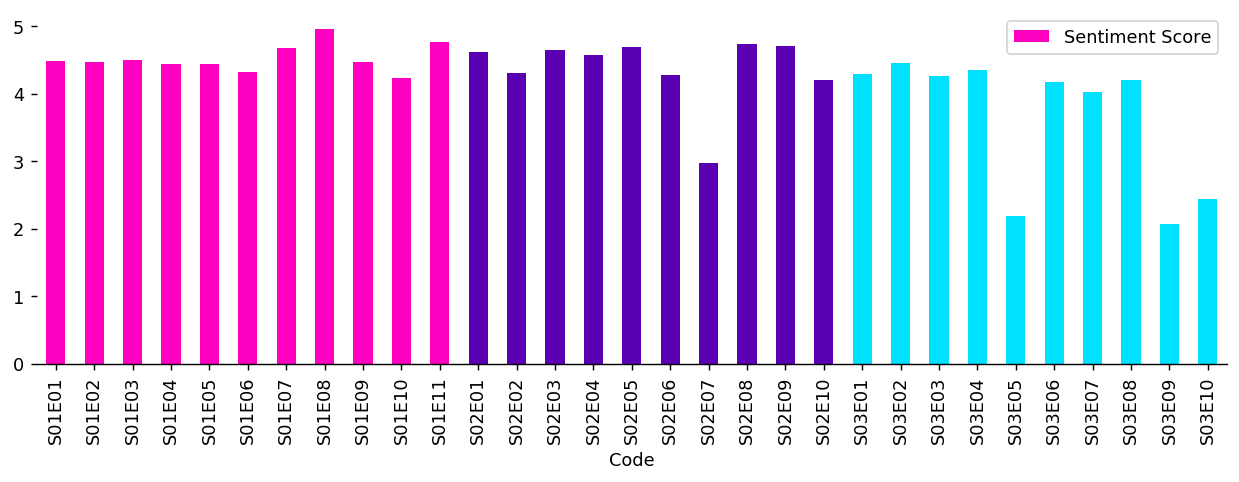

In [156]:
colors = []
df_ep['Season'] = "None"

# For every episode
for i in range(0,len(df_ep)):
  code = df_ep.iloc[i]['Code']

  if("S01" in code):
    colors.append(color_palet["flashy pink"])
    df_ep.set_value(i,'Season', 'Season 1')
  elif ("S02" in code):
    colors.append(color_palet["flashy purple"])
    df_ep.set_value(i,'Season', 'Season 2')
  elif ("S03" in code):
    colors.append(color_palet["flashy blue"])
    df_ep.set_value(i,'Season', 'Season 3')

fig = plt.figure(figsize=(12,8),dpi=128)

ax1 = fig.add_subplot(211)
df_ep.plot.bar(x='Code', y='Sentiment Score', rot=90, color=colors, ax=ax1)

# removing axes
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)

plt.savefig(path_plots + "sentiment_score_ep.png", format='png', transparent=True, bbox_inches='tight')

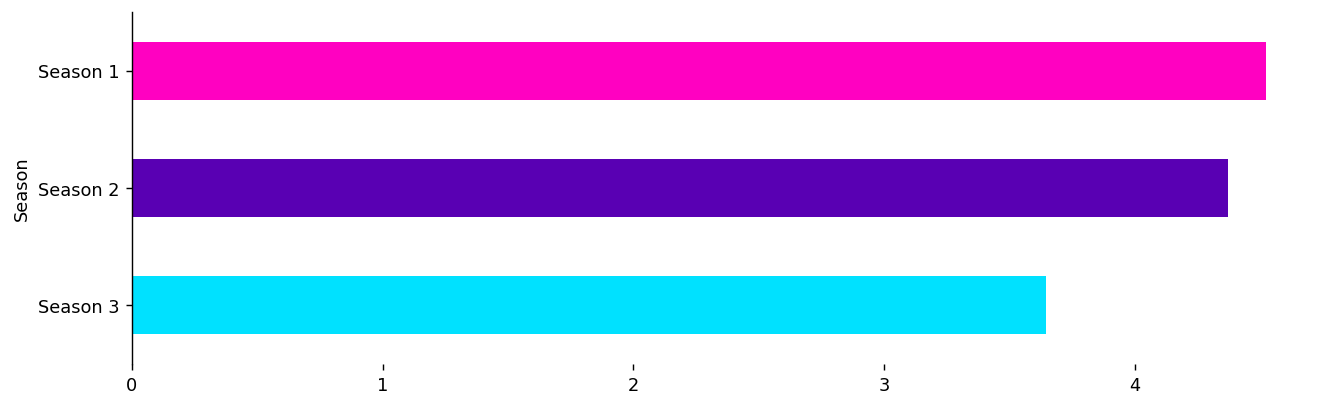

In [161]:
fig = plt.figure(figsize=(12,8),dpi=128)

colors = [color_palet["flashy blue"],color_palet["flashy purple"],color_palet["flashy pink"]]
ax2 = fig.add_subplot(212)
df_ep.groupby('Season')['Sentiment Score'].mean().sort_values().plot(kind='barh', ax=ax2, color = colors)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

plt.savefig(path_plots + "sentiment_score_season.png", format='png', transparent=True, bbox_inches='tight')

## Compute the TF-IDF

### Season 1

In [0]:
# TF Term Frequency 
s1_count = {}
for ii in s1_tk:
    if ii in s1_count:
        s1_count[ii] += 1
    else:
        s1_count[ii] = 1
  
# IDF Inverse Data Frequency
s1_idf = {}
for ii in s1_count:
    if ii in s2_tk and ii in s3_tk:
      n = 3
    elif ii in s2_tk or s3_tk :
      n = 2
    else:
      n = 1
    s1_idf[ii]=math.log(3/n)

# TF-IDF
s1_tfidf = {}
for ii in s1_count:
    s1_tfidf[ii] = s1_count[ii] * s1_idf[ii]

In [79]:
#10 most popular words in either of parties
print("Top 10 words of S1:")
c1 = Counter(s1_tfidf)
h1 = c1.most_common(10)
for ii in h1:
    print(ii[0])

Top 10 words of S1:
meeseeks
needful
snuffles
bloom
jacob
pluto
dream
pancakes
doofus
science


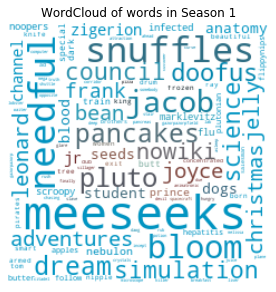

In [80]:
f = plt.figure(figsize=[16,8])

# Season 1
# Photo source: 
text_s1 = ""
for ii in s1_count:
    text_s1 += ((ii + ' ') * round(s1_tfidf[ii]))

# prepare the mask
response = requests.get('https://i.pinimg.com/236x/99/b2/73/99b273950aa91aaf1afd9f70e6c07099--rick-and-morty-tees.jpg')
mask = np.array(PIL.Image.open(BytesIO(response.content)))

# create the wordcloud
wc =  WordCloud(background_color="white", mode="RGBA", max_words=200, mask=mask, collocations=False).generate(text_s1)

image_colors = wordcloud.ImageColorGenerator(mask)

f.add_subplot(1, 3, 1)
plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud of words in Season 1")

# Show both wordclouds
plt.show(block=True)

### Season 2

In [0]:
# TF Term Frequency 
s2_count = {}
for ii in s2_tk:
    if ii in s2_count:
        s2_count[ii] += 1
    else:
        s2_count[ii] = 1
  
# IDF Inverse Data Frequency
s2_idf = {}
for ii in s2_count:
    if ii in s1_tk and ii in s3_tk:
      n = 3
    elif ii in s1_tk or s3_tk :
      n = 2
    else:
      n = 1
    s2_idf[ii]=math.log(3/n)

# TF-IDF
s2_tfidf = {}
for ii in s2_count:
    s2_tfidf[ii] = s2_count[ii] * s2_idf[ii]

In [82]:
#10 most popular words in either of parties
print("Top 10 words of S2:")
c2 = Counter(s2_tfidf)
h2 = c2.most_common(10)
for ii in h2:
    print(ii[0])

Top 10 words of S2:
testicle
gary
jerrys
feels
purge
deer
doctor
poopybutthole
nathan
summers


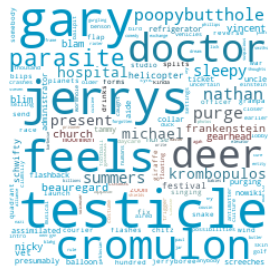

In [83]:
f = plt.figure(figsize=[16,8])

# Season 2
# Photo source: 
text_s2 = ""
for ii in s2_count:
    text_s2 += ((ii + ' ') * round(s2_tfidf[ii]))

# prepare the mask
response = requests.get('https://i.pinimg.com/236x/99/b2/73/99b273950aa91aaf1afd9f70e6c07099--rick-and-morty-tees.jpg')
mask = np.array(PIL.Image.open(BytesIO(response.content)))

# create the wordcloud
wc =  WordCloud(background_color="white", mode="RGBA", max_words=200, mask=mask, collocations=False).generate(text_s2)

image_colors = wordcloud.ImageColorGenerator(mask)

f.add_subplot(1, 3, 1)
plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
# plt.title("WordCloud of words in Season 1")

# Show both wordclouds
plt.show(block=True)

### Season 3

In [0]:
# TF Term Frequency 
s3_count = {}
for ii in s3_tk:
    if ii in s3_count:
        s3_count[ii] += 1
    else:
        s3_count[ii] = 1
  
# IDF Inverse Data Frequency
s3_idf = {}
for ii in s3_count:
    if ii in s2_tk and ii in s3_tk:
      n = 3
    elif ii in s2_tk or s3_tk :
      n = 2
    else:
      n = 1
    s3_idf[ii]=math.log(3/n)

# TF-IDF
s3_tfidf = {}
for ii in s3_count:
    s3_tfidf[ii] = s3_count[ii] * s3_idf[ii]

In [85]:
#10 most popular words in either of parties
print("Top 10 words of S3:")
c3 = Counter(s3_tfidf)
h3 = c3.most_common(10)
for ii in h3:
    print(ii[0])

Top 10 words of S3:
pickle
toxic
ants
citadel
wong
candidate
mechanical
campaign
manager
cornvelious


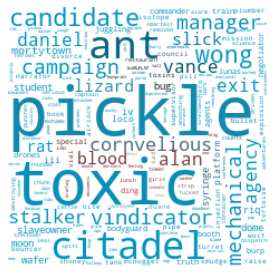

In [86]:
f = plt.figure(figsize=[16,8])

# Season 2
# Photo source: 
text_s3 = ""
for ii in s3_count:
    text_s3 += ((ii + ' ') * round(s3_tfidf[ii]))

# prepare the mask
response = requests.get('https://i.pinimg.com/236x/99/b2/73/99b273950aa91aaf1afd9f70e6c07099--rick-and-morty-tees.jpg')
mask = np.array(PIL.Image.open(BytesIO(response.content)))

# create the wordcloud
wc =  WordCloud(background_color="white", mode="RGBA", max_words=200, mask=mask, collocations=False).generate(text_s3)

image_colors = wordcloud.ImageColorGenerator(mask)

f.add_subplot(1, 3, 1)
plt.imshow(wc.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
# plt.title("WordCloud of words in Season 1")

# Show both wordclouds
plt.show(block=True)